In [169]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from pandas import DataFrame, DatetimeIndex, Timestamp, concat
from scipy.stats import combine_pvalues
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from icefreearcticml.constants import (
    MODELS,
    MODEL_COLOURS,
    MULTI_LIANG_RES_NAMES,
    VAR_YLABELS_SHORT,
    VARIABLES as VAR_NAMES,
)
from icefreearcticml.utils import (
    calculate_first_icefree_year,
    filter_by_years,
    read_model_data_all,
)

MODEL_NAMES = MODELS[:-1]   # Exclude 'Observations' from the model names
VARIABLES_ = VAR_NAMES[:-2] # Exclude swfd and lwfd

In [71]:
model_data = read_model_data_all()

In [72]:
model_ensemble_icefree_years = {
    model: calculate_first_icefree_year(model_data["ssie"][model])
    for model in MODEL_NAMES
}

## Functions

In [163]:
# Data Functions

def get_datetime_index(start_year: int, end_year: int) -> DatetimeIndex:
    dt_list = [
        f"{year}-01-01" for year in range(start_year, end_year+1)
    ]
    return DatetimeIndex(dt_list)

def get_x(train_config: TrainConfig, period: str, detrend: bool = False) -> np.ndarray:
    if period in ("simul", "simulation"):
        start, end = train_config.simul_start, train_config.simul_end
    elif period in ("emul", "emulation"):
        start, end = train_config.emul_start, train_config.emul_end
    xs = []
    ensemble_means = {}
    for x_var in train_config.x_vars:
        res = filter_by_years(model_data[x_var][train_config.model_name], start, end)
        if detrend:
            ensemble_mean = res.mean(axis=1)
            ensemble_means[x_var] = ensemble_mean
            res = res.subtract(ensemble_mean, axis=0)
        xs.append(res)
    if detrend:
        return np.stack(xs), ensemble_means
    return np.stack(xs), None

def get_x_train_test(
        x: np.ndarray,
        train_config: TrainConfig,
    ) -> tuple[np.array]:
    X_train = x[:, :, train_config.train_members].reshape(-1, len(train_config.x_vars))
    X_test = x[:, :, train_config.test_members].reshape(-1, len(train_config.x_vars))
    return X_train, X_test

def get_reshaped(x: np.ndarray, nt: int, ensembles: list[int]) -> DataFrame:
    return DataFrame(x.reshape((nt, len(ensembles))), columns=ensembles)

def get_train_test_ensembles(n: int, train_split: float) -> tuple[list]:
    n_train = int(n * train_split)
    n_test = n - n_train

    train_ensembles = select_ensembles(n, n_train)
    test_ensembles = select_remaining(n, train_ensembles)

    return train_ensembles, test_ensembles

def select_ensembles(n: int, x: int) -> list[int]:
    return random.sample(range(n), x)

def select_remaining(n: int, selected_ensembles: list[int]) -> list[int]:
    return [i for i in range(n) if i not in selected_ensembles]

def get_y(train_config: TrainConfig, period: str, detrend: bool = False) -> np.ndarray:
    if period in ("simul", "simulation"):
        start, end = train_config.simul_start, train_config.simul_end
    elif period in ("emul", "emulation"):
        start, end = train_config.emul_start, train_config.emul_end
    res = filter_by_years(
        model_data[train_config.y_var][train_config.model_name], start, end,
    )
    if detrend:
        ensemble_mean = res.mean(axis=1)
        res = res.subtract(ensemble_mean, axis=0)
        return res.to_numpy(), ensemble_mean
    return res.to_numpy(), None

def get_y_train_test(
        y: np.ndarray,
        train_config: TrainConfig,
    ) -> tuple[np.ndarray]:
    y_train = y[:, train_config.train_members].flatten()
    y_test = y[:, train_config.test_members].flatten()
    return y_train, y_test


class Output:

    def __init__(
            self,
            y_test_emul: DataFrame,
            y_pred_emul: DataFrame,
            y_test_simul: DataFrame,
            y_pred_simul: DataFrame,
            train_config: DataFrame,
            model_res: dict,
        ) -> None:
        self.y_test_emul = y_test_emul
        self.y_pred_emul = y_pred_emul
        self.y_test_simul = y_test_simul
        self.y_pred_simul = y_pred_simul
        self.train_config = train_config
        self.model_res = model_res
        

# Model functions

def get_emulated(
        model: "Model",
        train_config: TrainConfig,
    ) -> DataFrame:
    X_emul, _ = get_x(train_config, "emul")
    _, X_emul_test = get_x_train_test(X_emul, train_config)

    y_emul = model.predict(X_emul_test)
    y_emul_df = get_reshaped(y_emul, X_emul.shape[1], train_config.test_members)
    y_emul_df.index = get_datetime_index(train_config.emul_start, train_config.emul_end)

    return y_emul_df

def get_emulated_ice_free_years(train_config: TrainConfig, n_iter: int) -> list[int]:
    n_iter = 100

    X = get_x(train_config, "simul")

    ice_free_years_emul = []
    for _ in range(n_iter):

        train_config.set_train_test_members(X.shape)

        y = get_y(train_config, "simul")

        X_train, X_test = get_x_train_test(X, train_config)
        y_train, y_test = get_y_train_test(y, train_config)

        reg_res = get_regression(X_train, y_train, X_test, y_test)
        y_pred_emul = get_emulated(reg_res["model"], train_config)

        ice_free_years_emul = [*ice_free_years_emul, *calculate_first_icefree_year(y_pred_emul).dt.year.to_list()]

    return ice_free_years_emul

def get_random_forest(
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_test: np.ndarray,
        y_test: np.ndarray,
        sample_weight: list[float] | None = None,
        **rf_kwargs: dict,
    ) -> dict:
    model = RandomForestRegressor(**rf_kwargs)
    model.fit(x_train, y_train, sample_weight=sample_weight)
    y_pred = model.predict(x_test)
    return {
        "y_pred": y_pred,
        "mse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
        "model": model,
    }

def get_regression(
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_test: np.ndarray,
        y_test: np.ndarray,
        sample_weight: list[float] | None = None,
    ) -> dict:
    model = LinearRegression()
    model.fit(x_train, y_train, sample_weight=sample_weight)
    y_pred = model.predict(x_test)
    return {
        "y_pred": y_pred,
        "mse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
        "model": model,
    }

def get_y_emulated_outputs(model: "Model", train_config: TrainConfig) -> tuple[DataFrame]:
    y_pred_emul = get_emulated(model, train_config).clip(0)
    y_test_emul = filter_by_years(
        model_data[train_config.y_var][train_config.model_name],
        train_config.emul_start,
        train_config.emul_end,
    )[train_config.test_members]
    return y_test_emul, y_pred_emul

def get_y_simulated_outputs(y_test: np.ndarray, y_pred: np.ndarray, train_config: TrainConfig) -> tuple[DataFrame]:
    simul_index = get_datetime_index(train_config.simul_start, train_config.simul_end)
    y_test_simul = get_reshaped(y_test, train_config.n_time_steps, train_config.test_members)
    y_test_simul.index = simul_index
    y_pred_simul = get_reshaped(y_pred, train_config.n_time_steps, train_config.test_members)
    y_pred_simul.index = simul_index
    return y_test_simul, y_pred_simul

# Plot functions
def plot_emulation(
        ax: "Ax",
        output: Output,
        model_type: str,
    ) -> None:
    # ax.text(Timestamp("2080-01-01"), 8, f"$MSE_E$={mse_ens:.2f}")
    # ax.text(Timestamp("2080-01-01"), 7.5, f"$MSE_O$={mse_obs:.2f}")
    model_color = MODEL_COLOURS[output.train_config.model_name]
    
    ax.plot(output.y_test_simul, color=model_color, linewidth=2)
    ax.plot(output.y_pred_simul, color="black", linestyle="--", linewidth=2)

    ax.plot(output.y_test_emul, color=model_color, linewidth=2)
    ax.plot(output.y_pred_emul, color="black", linestyle="--", linewidth=2)

    ax.plot([], [], color="black", linestyle="--", label="Model Prediction")
    ax.plot([], [], color=model_color, label="Ensemble Data")

    ax.axhline(y=1, color='black', linestyle=':', linewidth=2)
    ax.axvline(x=Timestamp(f"{output.train_config.simul_end}-01-01"), color='black', linestyle=':', linewidth=2)
    # ax.legend()
    ax.set_title(f"{output.train_config.model_name} - {output.train_config.y_var} {model_type}", x=0.5, size=20)
    ax.tick_params(labelsize=20)

def plot_ice_free_year_dist(ax: "Ax", model_name: str, emulated_years: list, data_years: list) -> None:
    ax.hist(emulated_years, bins=50, density=True, label="Emulated")
    ax.hist(data_years, bins=50, density=True, label="Historic")
    ax.legend()
    ax.set_title(model_name)

# Causality

def calculate_combined_pvalues(p_values, var_liangs):
    p_array = np.array(p_values)
    return {
        var: combine_pvalues(p_array[:, i], method='fisher')[1]
            for i, var in enumerate(var_liangs)
    }

def calculate_liang_model_flows(liang_data, y, dt, n_iter):
    liang_indexes = []
    p_values = []

    for i in range(y.shape[1]):
        x = prepare_liang_array(liang_data, i, y[:, i])

        res = compute_liang_nvar_wrapper(x, dt, n_iter)

        tau = abs(res["tau"])
        p_value = calculate_pvalue(tau, res["error_tau"])

        liang_indexes.append(tau[:,4])
        p_values.append(p_value[:,4])

    return liang_indexes, p_values

def calculate_pvalue(tau, error_tau):
    z = tau / error_tau
    return np.exp(-0.717 * z - 0.416 * z**2)

def calculate_tau_avg(liang_indexes, var_liangs):
    tau_avg = np.nanmean(np.array(liang_indexes), axis=0)
    return dict(zip(var_liangs, tau_avg))

def calculate_all_liang_flows(
        model_data: dict,
        y_var: str,
        var_liangs: list[str],
        liang_start: str,
        liang_end: str,
        dt: int = 1,
        n_iter: int = 1000,
    ) -> dict:
    tau_avgs = {}
    combined_pvalues = {}
    ensemble_flows = {}
    ensemble_pvalues = {}
    for model in MODEL_NAMES:
        # Prepare data for liang flow calc
        ssie_liang = prepare_for_liang(model_data[y_var][model], liang_start, liang_end)
        liang_data = {
            var: prepare_for_liang(model_data[var][model], liang_start, liang_end) for var in var_liangs
        }
        # Liang flow calc
        liang_indexes, p_values = calculate_liang_model_flows(liang_data, ssie_liang, dt, n_iter)

        # Add ensemble flows and pvalues
        ensemble_flows[model] = np.array(liang_indexes)
        ensemble_pvalues[model] = p_values

        # Add ensemble mean flow and pvalue
        tau_avgs[model] = calculate_tau_avg(liang_indexes, var_liangs)
        combined_pvalues[model] = calculate_combined_pvalues(p_values, var_liangs)

    return {
        "tau_avgs": tau_avgs,
        "combined_pvalues": combined_pvalues,
        "ensemble_flows": ensemble_flows,
        "ensemble_pvalues": ensemble_pvalues,
    }

@jit(nopython=True) # accelerator
def compute_liang_nvar(x,dt,n_iter):
    
    # Function to compute absolute transfer of information from xj to xi (T)
    def compute_liang_index(detC,Deltajk,Ckdi,Cij,Cii):
        T = (1. / detC) * np.sum(Deltajk * Ckdi) * (Cij / Cii) # absolute rate of information flowing from xj to xi (nats per unit time) (equation (14))
        return T
    
    # Function to compute relative transfer of information from xj to xi (tau)
    def compute_liang_index_norm(detC,Deltaik,Ckdi,T_all,Tii,gii,Cii,Tji):
        selfcontrib = (1. / detC) * np.sum(Deltaik * Ckdi) # self-contribution (equation (15))
        transfer = np.sum(np.abs(T_all)) - np.abs(Tii) # all other transfers contribution (equation (20))
        noise = 0.5 * gii / Cii # noise contribution
        Z = np.abs(selfcontrib) + transfer + np.abs(noise) # normalizer (equation (20))
        tau = 100. * Tji / Z # relative rate of information flowing from xj to xi (%) (equation (19))
        return tau
    
    # Dimensions
    nvar = x.shape[0] # number of variables
    N = x.shape[1] # length of the time series (number of observations)
    
    # Compute tendency dx
    k = 1 # k = 1 (or 2 for highly chaotic and densely sampled systems)
    dx = np.zeros((nvar,N)) # initialization of dx (to have the same number of time steps as x)
    for i in np.arange(nvar):
        dx[i,0:N-k] = (x[i,k:N] - x[i,0:N-k]) / (k * dt) # Euler forward finite difference of x (equation (7))
    
    # Compute covariances and matrix determinant
    C = np.cov(x) # covariance matrix
    dC = np.empty_like(C) * 0.
    for i in np.arange(nvar):
        for j in np.arange(nvar):
            dC[j,i] = (np.sum((x[j,:] - np.nanmean(x[j,:])) * (dx[i,:] - np.nanmean(dx[i,:])))) / (N - 1.) # covariance between x and dx
    detC = np.linalg.det(C) # matrix determinant
    
    # Compute cofactors
    Delta = np.linalg.inv(C).T * detC # cofactor matrix (https://en.wikipedia.org/wiki/Minor_(linear_algebra))
    
    # Compute absolute transfer of information (T) and correlation coefficient (R)
    T = np.zeros((nvar,nvar))
    R = np.zeros((nvar,nvar))
    for i in np.arange(nvar):
        for j in np.arange(nvar):
            T[j,i] = compute_liang_index(detC,Delta[j,:],dC[:,i],C[i,j],C[i,i]) # compute T (transfer of information from xj to xi) and create matrix
            R[j,i] = C[i,j] / np.sqrt(C[i,i] * C[j,j]) # compute correlation coefficient and create correlation matrix
    
    # Compute noise terms
    g = np.zeros(nvar)
    for i in np.arange(nvar):
        a1k = np.dot(np.linalg.inv(C),dC[:,i]) # compute a1k coefficients based on matrix-vector product (see beginning of page 4 in Liang (2014))
        f1 = np.nanmean(dx[i,:])
        for k in np.arange(nvar):
            f1 = f1 - a1k[k] * np.nanmean(x[k,:])
        R1 = dx[i,:] - f1
        for k in np.arange(nvar):
            R1 = R1 - a1k[k] * x[k,:]
        Q1 = np.sum(R1**2.)       
        g[i] = Q1 * dt / N # equation (10)
    
    # Compute relative transfer of information (tau)
    tau = np.zeros((nvar,nvar))
    for i in np.arange(nvar):
        for j in np.arange(nvar):
            tau[j,i] = compute_liang_index_norm(detC,Delta[i,:],dC[:,i],T[:,i],T[i,i],g[i],C[i,i],T[j,i]) # compute tau and create matrix
    
    # Initialize error in T, tau and R
    boot_T = np.zeros((n_iter,nvar,nvar))
    boot_tau = np.zeros((n_iter,nvar,nvar))
    boot_R = np.zeros((n_iter,nvar,nvar))
    
    # Compute error in T, tau and R using bootstrap with replacement
    for it in np.arange(n_iter): # loop over bootstrap realizations

        # Resample x and dx
        index = np.arange(N)
        boot_index = np.random.choice(index,N,replace=True) # resample index
        boot_x = np.zeros((nvar,N))
        boot_dx = np.zeros((nvar,N))
        for t in np.arange(N):
            boot_x[:,t] = x[:,boot_index[t]] # x corresponding to resampled index
            boot_dx[:,t] = dx[:,boot_index[t]] # dx corresponding to resampled index
        
        # Compute covariances and matrix determinant based on resampled variables
        boot_C = np.cov(boot_x)
        boot_dC = np.empty_like(boot_C) * 0.
        for i in np.arange(nvar):
            for j in np.arange(nvar):
                boot_dC[j,i] = (np.sum((boot_x[j,:] - np.nanmean(boot_x[j,:])) * (boot_dx[i,:] - np.nanmean(boot_dx[i,:])))) / (N - 1.)
        boot_detC = np.linalg.det(boot_C)
        
        # Compute cofactors based on resampled variables
        boot_Delta = np.linalg.inv(boot_C).T * boot_detC

        # Compute absolute transfer of information (T) and correlation coefficient (R) based on resampled variables
        for i in np.arange(nvar):
            for j in np.arange(nvar):
                boot_T[it,j,i] = compute_liang_index(boot_detC,boot_Delta[j,:],boot_dC[:,i],boot_C[i,j],boot_C[i,i])
                boot_R[it,j,i] = boot_C[i,j] / np.sqrt(boot_C[i,i] * boot_C[j,j])
        
        # Compute noise terms based on resampled variables
        boot_g = np.zeros(nvar)
        for i in np.arange(nvar):
            a1k = np.dot(np.linalg.inv(boot_C),boot_dC[:,i])
            f1 = np.nanmean(boot_dx[i,:])
            for k in np.arange(nvar):
                f1 = f1 - a1k[k] * np.nanmean(boot_x[k,:])
            R1 = boot_dx[i,:] - f1
            for k in np.arange(nvar):
                R1 = R1 - a1k[k] * boot_x[k,:]
            Q1 = np.sum(R1**2.)       
            boot_g[i] = Q1 * dt / N

        # Compute relative transfer of information (tau) based on resampled variables
        for i in np.arange(nvar):
            for j in np.arange(nvar):
                boot_tau[it,j,i] = compute_liang_index_norm(boot_detC,boot_Delta[i,:],boot_dC[:,i],boot_T[it,:,i],boot_T[it,i,i],boot_g[i],boot_C[i,i],boot_T[it,j,i])

    # Compute error in T, tau and R (standard deviation of boostraped values)
    # error_T = np.nanstd(boot_T,axis=0)
    # error_tau = np.nanstd(boot_tau,axis=0)
    # error_R = np.nanstd(boot_R,axis=0)
    
    # Return result of function
    return T, tau, R, boot_T, boot_tau, boot_R

def compute_liang_nvar_wrapper(x, dt, n_iter):
    res = dict(zip(
        MULTI_LIANG_RES_NAMES,
        compute_liang_nvar(x, dt, n_iter),
    ))
    res["error_T"] = np.nanstd(res["error_T"],axis=0)
    res["error_tau"] = np.nanstd(res["error_tau"],axis=0)
    res["error_R"] = np.nanstd(res["error_R"],axis=0)
    return res

def plot_liang_tau_avgs(ax: "Ax", liang_res, var_liangs):
    ax.grid(linestyle='--')

    jitter = 0.1

    for j, var in enumerate(var_liangs):
        for i, model in enumerate(MODEL_NAMES):

            tau = liang_res["tau_avgs"][model][var]
            pvalue = liang_res["combined_pvalues"][model][var]
            x = j - 0.2 + i * jitter

            # Black circle if significant
            kwargs = {"edgecolors": 'black', "linewidths": 2} if pvalue <= 0.05 else {}

            ax.scatter(x, tau, label=model, c=MODEL_COLOURS[model], s=100, **kwargs)

    ax.set_xticks(range(len(var_liangs)))
    ax.set_xticklabels([VAR_YLABELS_SHORT[var] for var in var_liangs])
    ax.set_ylabel("Information Transfer")
    ax.axhline(0, color='black', linestyle='--')
    ax.set_ylim(-1, 30)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)

def prepare_liang_array(liang_data, i, y):
    data_list = []
    for var_data in liang_data.values():
        data_list.append(var_data[:, i])  # Access the ith column of each variable's data
    return np.array([*data_list, y])

def prepare_for_liang(data: DataFrame, start: str, end: str) -> DataFrame:
    filtered = filter_by_years(data, start, end).fillna(0)
    return subtract_ensemble_mean(filtered).to_numpy()

def subtract_ensemble_mean(model_data: DataFrame) -> DataFrame:
    return model_data.subtract(model_data.mean(axis=1), axis=0)

## GBMs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [60]:
X, ensemble_means_x = get_x(train_config, "simul", detrend=False)
train_config.set_train_test_members(X.shape)

y, ensemble_mean_y = get_y(train_config, "simul", detrend=False)

X_train, X_test = get_x_train_test(X, train_config)
y_train, y_test = get_y_train_test(y, train_config)

x_scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [61]:
# Define XGBoost model with regularization
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,  # Use early stopping instead of fixed number
    learning_rate=0.05,
    max_depth=5,  # Limit depth to prevent overfitting
    min_child_weight=5,  # Regularization parameter
    subsample=0.8,  # Stochastic gradient boosting
    colsample_bytree=0.8,  # Feature sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42
)

# Use early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [62]:
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))

print(f"\nXGBoost Performance:")
print(f"Training R²: {xgb_train_r2:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")
print(f"Training RMSE: {xgb_train_rmse:.4f}")
print(f"Test RMSE: {xgb_test_rmse:.4f}")


XGBoost Performance:
Training R²: 0.8986
Test R²: 0.6301
Training RMSE: 0.5760
Test RMSE: 1.2983


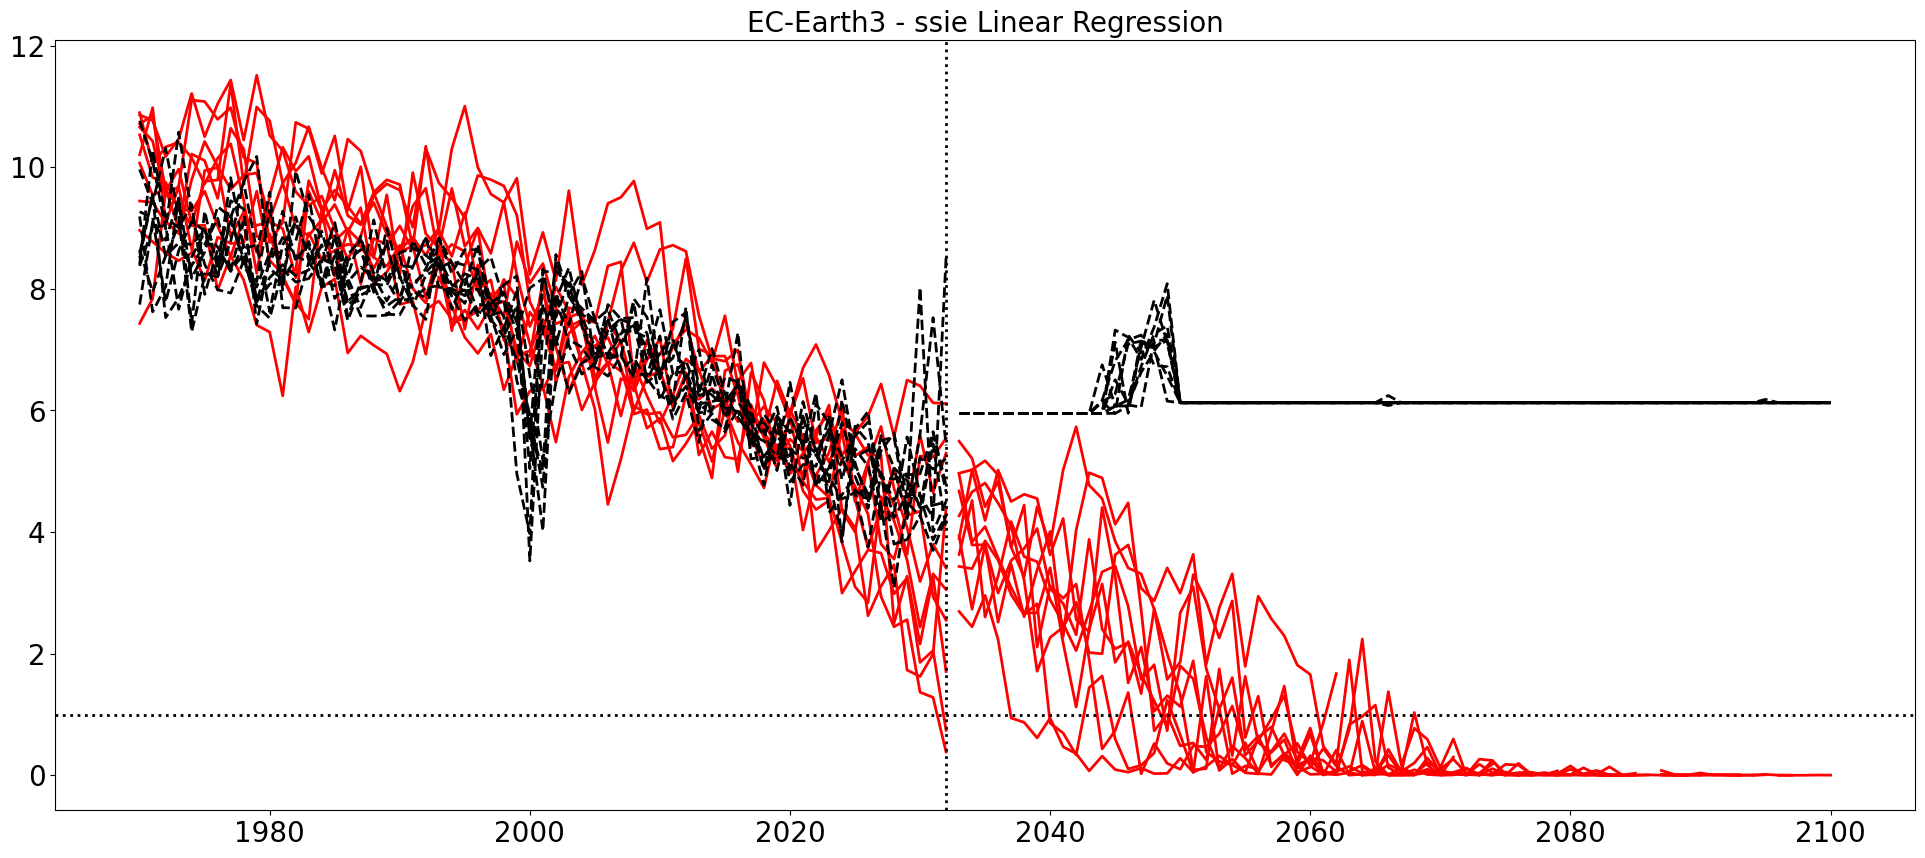

In [63]:
y_test_simul, y_pred_simul = get_y_simulated_outputs(y_test, xgb_test_pred, train_config)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24, 10))
output = Output(
    y_test_emul=y_test_emul,
    y_pred_emul=y_pred_emul,
    y_test_simul=y_test_simul,
    y_pred_simul=y_pred_simul,
    train_config=train_config,
    model_res=model_res,
)
plot_emulation(axes, output, "Linear Regression")

In [64]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Create base model
xgb_tune = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    random_state=42
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_tune,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=0
)

In [40]:
# Fit grid search
grid_search.fit(X_train_scaled, y_train_scaled)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'reg_alpha': [0, 0.1, ...], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [44]:
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

best_xgb_train_pred = best_xgb.predict(X_train_scaled)
best_xgb_test_pred = best_xgb.predict(X_test_scaled)

best_xgb_train_r2 = r2_score(y_train_scaled, best_xgb_train_pred)
best_xgb_test_r2 = r2_score(y_test_scaled, best_xgb_test_pred)

print(f"\nTuned XGBoost Performance:")
print(f"Training R²: {best_xgb_train_r2:.4f}")
print(f"Test R²: {best_xgb_test_r2:.4f}")


Tuned XGBoost Performance:
Training R²: 0.9857
Test R²: 0.4933


In [96]:
X, ensemble_means_x = get_x(train_config, "simul", detrend=False)
train_config.set_train_test_members(X.shape)

y, ensemble_mean_y = get_y(train_config, "simul", detrend=False)

X_train, X_test = get_x_train_test(X, train_config)
y_train, y_test = get_y_train_test(y, train_config)

x_scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [97]:
# 11. Ensemble of different models
# Sometimes combining multiple models works better than any single model
from sklearn.ensemble import VotingRegressor

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,  # Use early stopping instead of fixed number
    learning_rate=0.05,
    max_depth=5,  # Limit depth to prevent overfitting
    min_child_weight=5,  # Regularization parameter
    subsample=0.8,  # Stochastic gradient boosting
    colsample_bytree=0.8,  # Feature sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42
)

# Define LightGBM model with regularization
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=20,  # Limit complexity
    min_child_samples=10,  # Regularization parameter
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42
)

# Create ensemble of XGBoost and LightGBM
ensemble = VotingRegressor([
    ('xgb', xgb_model),
    ('lgb', lgb_model),
])

ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f"\nEnsemble (XGBoost + LightGBM) Performance: Test R² = {ensemble_r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 4
[LightGBM] [Info] Start training from score 7.143035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

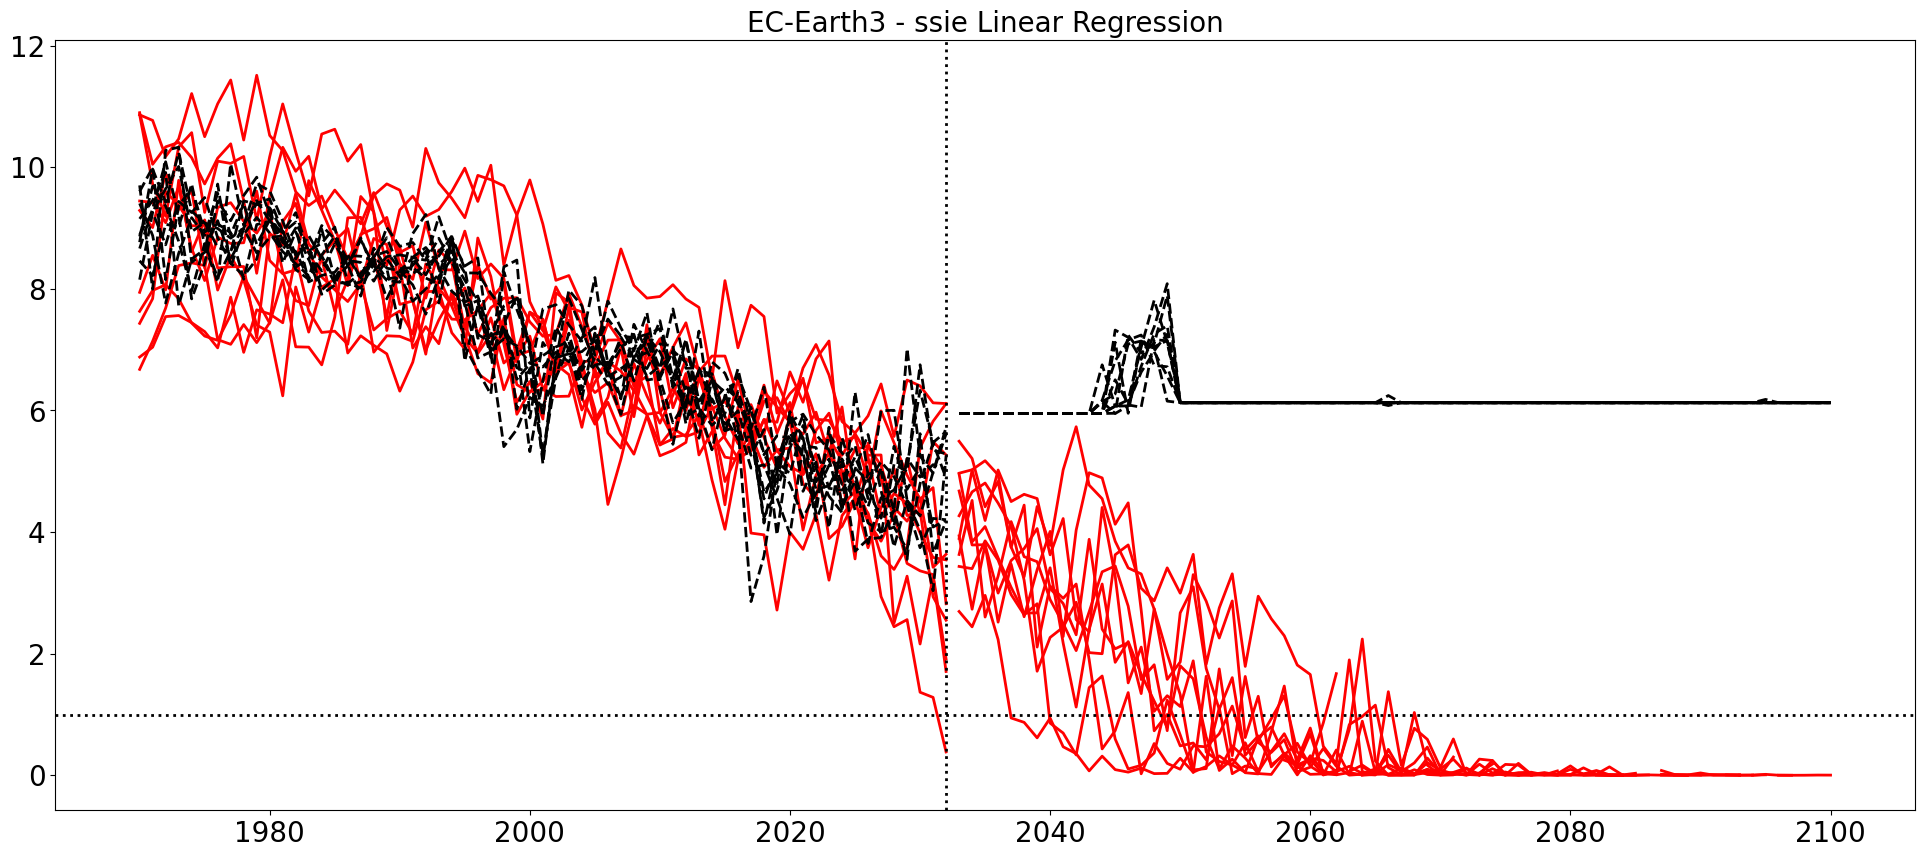

In [98]:
y_test_simul, y_pred_simul = get_y_simulated_outputs(y_test, ensemble_pred, train_config)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24, 10))
output = Output(
    y_test_emul=y_test_emul,
    y_pred_emul=y_pred_emul,
    y_test_simul=y_test_simul,
    y_pred_simul=y_pred_simul,
    train_config=train_config,
    model_res=model_res,
)
plot_emulation(axes, output, "Linear Regression")

Text(0.5, 1.0, 'XGBoost Residuals')

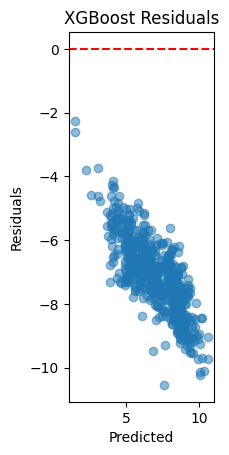

In [86]:
# XGBoost residuals
plt.subplot(1, 3, 1)
residuals = y_test_scaled - ensemble_pred
plt.scatter(ensemble_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('XGBoost Residuals')

In [99]:
def analyze_residuals(model, X, y, X_test, y_test):
    # Train predictions and residuals
    y_pred_train = model.predict(X)
    residuals_train = y - y_pred_train
    
    # Test predictions and residuals
    y_pred_test = model.predict(X_test)
    residuals_test = y_test - y_pred_test
    
    # Plot residuals
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Training residuals
    axes[0, 0].scatter(y_pred_train, residuals_train, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Training Residuals')
    
    # Test residuals
    axes[0, 1].scatter(y_pred_test, residuals_test, alpha=0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Test Residuals')
    
    # Residual autocorrelation
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(residuals_test, ax=axes[0, 2], lags=20)
    axes[0, 2].set_title('Residual Autocorrelation')
    
    # QQ plot for normality
    stats.probplot(residuals_test, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('QQ Plot of Residuals')
    
    # Residual distribution
    axes[1, 1].hist(residuals_test, bins=30, alpha=0.7)
    axes[1, 1].set_xlabel('Residual Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residual Distribution')
    
    # Actual vs Predicted
    axes[1, 2].scatter(y_test, y_pred_test, alpha=0.5)
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    axes[1, 2].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[1, 2].set_xlabel('Actual')
    axes[1, 2].set_ylabel('Predicted')
    axes[1, 2].set_title('Actual vs Predicted')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    train_r2 = r2_score(y, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Train-Test R² Gap: {train_r2 - test_r2:.4f}")
    
    return residuals_test

In [ ]:
def time_aware_loss(y_true, y_pred):
    residuals = y_true - y_pred

    autocorr_penalty = 0
    for lag in range(1, min(6, len(residuals))):
        autocorr = np.corrcoef(residuals[:-lag], residuals[lag:])[0, 1]
        autocorr_penalty += abs(autocorr) * 0.1  # Penalize autocorrelation
    
    mse = np.mean(residuals**2)
    return mse * (1 + autocorr_penalty)

def time_aware_xgb_objective(y_true, y_pred):
    residuals = y_true - y_pred
    grad = -2 * residuals  # Gradient of MSE
    
    hess = 2 * np.ones_like(y_true)
    
    for lag in range(1, min(4, len(residuals))):
        autocorr = np.corrcoef(residuals[:-lag], residuals[lag:])[0, 1]
        grad += 0.05 * autocorr * np.sign(residuals)
    
    return grad, hess

def time_aware_cross_val_score(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        scores.append(score)
    
    return np.mean(scores)

def optimize_gbm_hyperparameters(X, y):
    xgb_param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 1500],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0.5, 1, 1.5, 2],
        'min_child_weight': [1, 3, 5, 7]
    }
    
    # LightGBM parameter grid
    lgb_param_grid = {
        'num_leaves': [15, 31, 63],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 1500],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0.5, 1, 1.5, 2],
        'min_child_samples': [5, 10, 20, 30]
    }
    
    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # XGBoost optimization
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_search = RandomizedSearchCV(
        xgb_model, xgb_param_grid, n_iter=50, scoring='r2', 
        cv=tscv, verbose=0, n_jobs=-1, random_state=42
    )
    xgb_search.fit(X, y)
    
    # LightGBM optimization
    lgb_model = lgb.LGBMRegressor(random_state=42)
    lgb_search = RandomizedSearchCV(
        lgb_model, lgb_param_grid, n_iter=50, scoring='r2', 
        cv=tscv, verbose=0, n_jobs=-1, random_state=42
    )
    lgb_search.fit(X, y)
    
    return xgb_search.best_estimator_, lgb_search.best_estimator_

def create_stacking_ensemble(X, y):
    xgb_opt, lgb_opt = optimize_gbm_hyperparameters(X, y)
    
    estimators = [
        ('xgb', xgb_opt),
        ('lgb', lgb_opt)
    ]
    stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=1.0),
        cv=TimeSeriesSplit(n_splits=5),
        n_jobs=-1
    )
    
    return stacking_regressor


def advanced_gbm_optimization(X_train, y_train, X_test, y_test):
    stacking_model = create_stacking_ensemble(X_train, y_train)
    stacking_model.fit(X_train, y_train)
    
    residuals = analyze_residuals(stacking_model, X_train, y_train, X_test, y_test)
    
    xgb_models = {}
    objectives = ['reg:squarederror', 'reg:absoluteerror', 'reg:gamma', 'reg:tweedie']
    
    for obj in objectives:
        xgb_model = xgb.XGBRegressor(
            objective=obj,
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        
        xgb_model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        y_pred = xgb_model.predict(X_test)
        test_r2 = r2_score(y_test, y_pred)
        xgb_models[obj] = test_r2
    
    lgb_models = {}
    objectives = ['regression', 'regression_l1', 'huber', 'fair']
    
    for obj in objectives:
        lgb_model = lgb.LGBMRegressor(
            objective=obj,
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        y_pred = lgb_model.predict(X_test)
        test_r2 = r2_score(y_test, y_pred)
        lgb_models[obj] = test_r2
        print(f"LightGBM with {obj}: Test R² = {test_r2:.4f}")
    
    return stacking_model, xgb_models, lgb_models





In [111]:
X, ensemble_means_x = get_x(train_config, "simul", detrend=False)
train_config.set_train_test_members(X.shape)

y, ensemble_mean_y = get_y(train_config, "simul", detrend=False)

X_train, X_test = get_x_train_test(X, train_config)
y_train, y_test = get_y_train_test(y, train_config)

x_scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [112]:
def time_aware_xgb_objective(y_true, y_pred):
    residuals = y_true - y_pred
    grad = -2 * residuals  # Gradient of MSE
    
    hess = 2 * np.ones_like(y_true)
    
    for lag in range(1, min(4, len(residuals))):
        autocorr = np.corrcoef(residuals[:-lag], residuals[lag:])[0, 1]
        grad += 0.05 * autocorr * np.sign(residuals)
    
    return grad, hess

xgb_models = {}
objectives = ['reg:squarederror', 'reg:absoluteerror', 'reg:gamma', 'reg:tweedie']

for obj in objectives:
    xgb_model = xgb.XGBRegressor(
        objective=obj,
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    y_pred = xgb_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    xgb_models[obj] = test_r2

In [121]:
xgb_param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'min_child_weight': [1, 3, 5, 7]
}
tscv = TimeSeriesSplit(n_splits=5)

objectives = ['reg:squarederror', 'reg:absoluteerror', 'reg:gamma', 'reg:tweedie']

xgb_models = {}
for obj in objectives:
    xgb_model = xgb.XGBRegressor(objective=obj, random_state=42)
    xgb_search = RandomizedSearchCV(
        xgb_model, xgb_param_grid, n_iter=50, scoring='r2', 
        cv=tscv, verbose=0, n_jobs=-1, random_state=42
    )
    xgb_search.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    y_pred = xgb_search.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    xgb_models[obj] = test_r2

In [123]:
xgb_models

{'reg:squarederror': 0.5260331794606543,
 'reg:absoluteerror': 0.5967102173069863,
 'reg:gamma': 0.6178529692662591,
 'reg:tweedie': 0.5027727299879647}

In [114]:
xgb_model = xgb.XGBRegressor(
    objective=time_aware_xgb_objective,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

test_r2 = r2_score(y_test, y_pred)
test_r2

0.5255978746476808

## pyTorch Forecasting

In [77]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.models.base import Prediction
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer

from pytorch_forecasting.models import DeepAR

from pytorch_forecasting.data import TorchNormalizer

In [164]:
def get_melt(var_data: DataFrame, var: str) -> DataFrame:
    return var_data.reset_index(names="time").melt(id_vars=["time"], var_name="member", value_name=var)

def get_timeseries_dataloader(data: DataFrame, train_config: TrainConfig, train: bool) -> TimeSeriesDataSet:
    dataset = TimeSeriesDataSet(
        data,
        time_idx="time",
        group_ids=["member"],
        target=train_config.y_var,
        max_encoder_length=train_config.max_encoder_length,
        max_prediction_length=train_config.max_prediction_length,
        time_varying_known_reals=train_config.x_vars,
        # target_normalizer=TorchNormalizer(),
    )
    return dataset.to_dataloader(train=train, batch_size=32, num_workers=0)

def get_timeseries_model(train_dataloader: DataLoader, val_dataloader: DataLoader) -> "Module":
    model = TemporalFusionTransformer.from_dataset(train_dataloader.dataset)
    trainer = Trainer(max_epochs=15, accelerator="auto", enable_progress_bar=False)
    trainer.fit(model, train_dataloader, val_dataloader)
    return model

def reshape_prediction(prediction: Prediction, index: list, target: str) -> DataFrame:
    output_df = prediction.index
    output_df[target] = prediction.output.cpu().detach().numpy().ravel()
    output_df = output_df.set_index(["time", "member"])[target].unstack()
    output_df.index = index
    return output_df

class TrainConfig:

    def __init__(
            self,
            y_var: str,
            x_vars: list[str],
            train_split: float,
            simul_start: int,
            simul_end: int,
            emul_start: int,
            emul_end: int,
            model_name: str,
            **kwargs: dict,
        ) -> None:
        self.y_var = y_var
        self.x_vars = x_vars
        self.train_split = train_split
        self.simul_start = simul_start
        self.simul_end = simul_end
        self.emul_start = emul_start
        self.emul_end = emul_end
        self.model_name = model_name
        for k, v in kwargs.items():
            setattr(self, k, v)
        self.set_simul_datetime_index()

    def get_emul_test_df(self) -> DataFrame:
        return filter_by_years(
            model_data[self.y_var][self.model_name],
            self.emul_start, self.emul_end
        )[self.test_members]
    
    def set_all_data(self) -> None:
        merged = None
        for var in self.all_vars:
            res = filter_by_years(model_data[var][self.model_name], self.simul_start, self.emul_end).fillna(0)
            res = get_melt(res, var)
            if merged is None:
                merged = res
            else:
                merged = merged.merge(res, on=["member", "time"])

        merged["time"] = merged["time"].dt.year
        self.all_data = merged

    def set_simul_datetime_index(self) -> DatetimeIndex:
        start = self.simul_start
        if hasattr(self, "max_encoder_length"):
            start += self.max_encoder_length
        self.simul_index = get_datetime_index(start, self.simul_end)

    def set_emul_df(self) -> None:
        self.emul_df = self.all_data[self.all_data["time"] > (self.simul_end - self.max_encoder_length)]
        self.emul_df = self.emul_df[self.emul_df["member"].isin(self.test_members)]

    def set_simul_data(self) -> None:
        self.simul_df = self.all_data[self.all_data["time"] <= self.simul_end]

        self.n_time_steps = len(self.simul_df["time"].unique())
        self.n_members = len(self.simul_df["member"].unique())
        
        self.set_train_test_members()

        self.simul_train = self.simul_df[self.simul_df["member"].isin(self.train_members)]
        self.simul_test = self.simul_df[self.simul_df["member"].isin(self.test_members)]

    def get_simul_test_df(self) -> DataFrame:
        y_test_simul = self.simul_df[self.simul_df["time"] >= (self.simul_start + self.max_encoder_length)]
        y_test_simul = y_test_simul.set_index(["time", "member"])["ssie"].unstack()[self.test_members]
        y_test_simul.index = self.simul_index
        return y_test_simul

    def set_train_test_members(self) -> None:
        self.train_members, self.test_members = get_train_test_ensembles(self.n_members, self.train_split)

    @property
    def all_vars(self) -> list[str]:
        return [self.y_var, *self.x_vars]
    

class ModelData:

    def __init__(self, output_dict: dict) -> None:
        self.output_dict = output_dict

    def __getitem__(self, var: str):
        res = {}
        for model_name, output in self.output_dict.items():
            if output.train_config.y_var == var:
                res[model_name] = concat([output.y_pred_simul, output.y_pred_emul])
            else:
                res[model_name] = model_data[var][model_name]

        return res
    

class Output:

    def __init__(
            self,
            y_test_emul: DataFrame,
            y_pred_emul: DataFrame,
            y_test_simul: DataFrame,
            y_pred_simul: DataFrame,
            train_config: DataFrame,
            model_res: dict,
        ) -> None:
        self.y_test_emul = y_test_emul
        self.y_pred_emul = y_pred_emul
        self.y_test_simul = y_test_simul
        self.y_pred_simul = y_pred_simul
        self.train_config = train_config
        self.model_res = model_res
    
    

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 64     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         

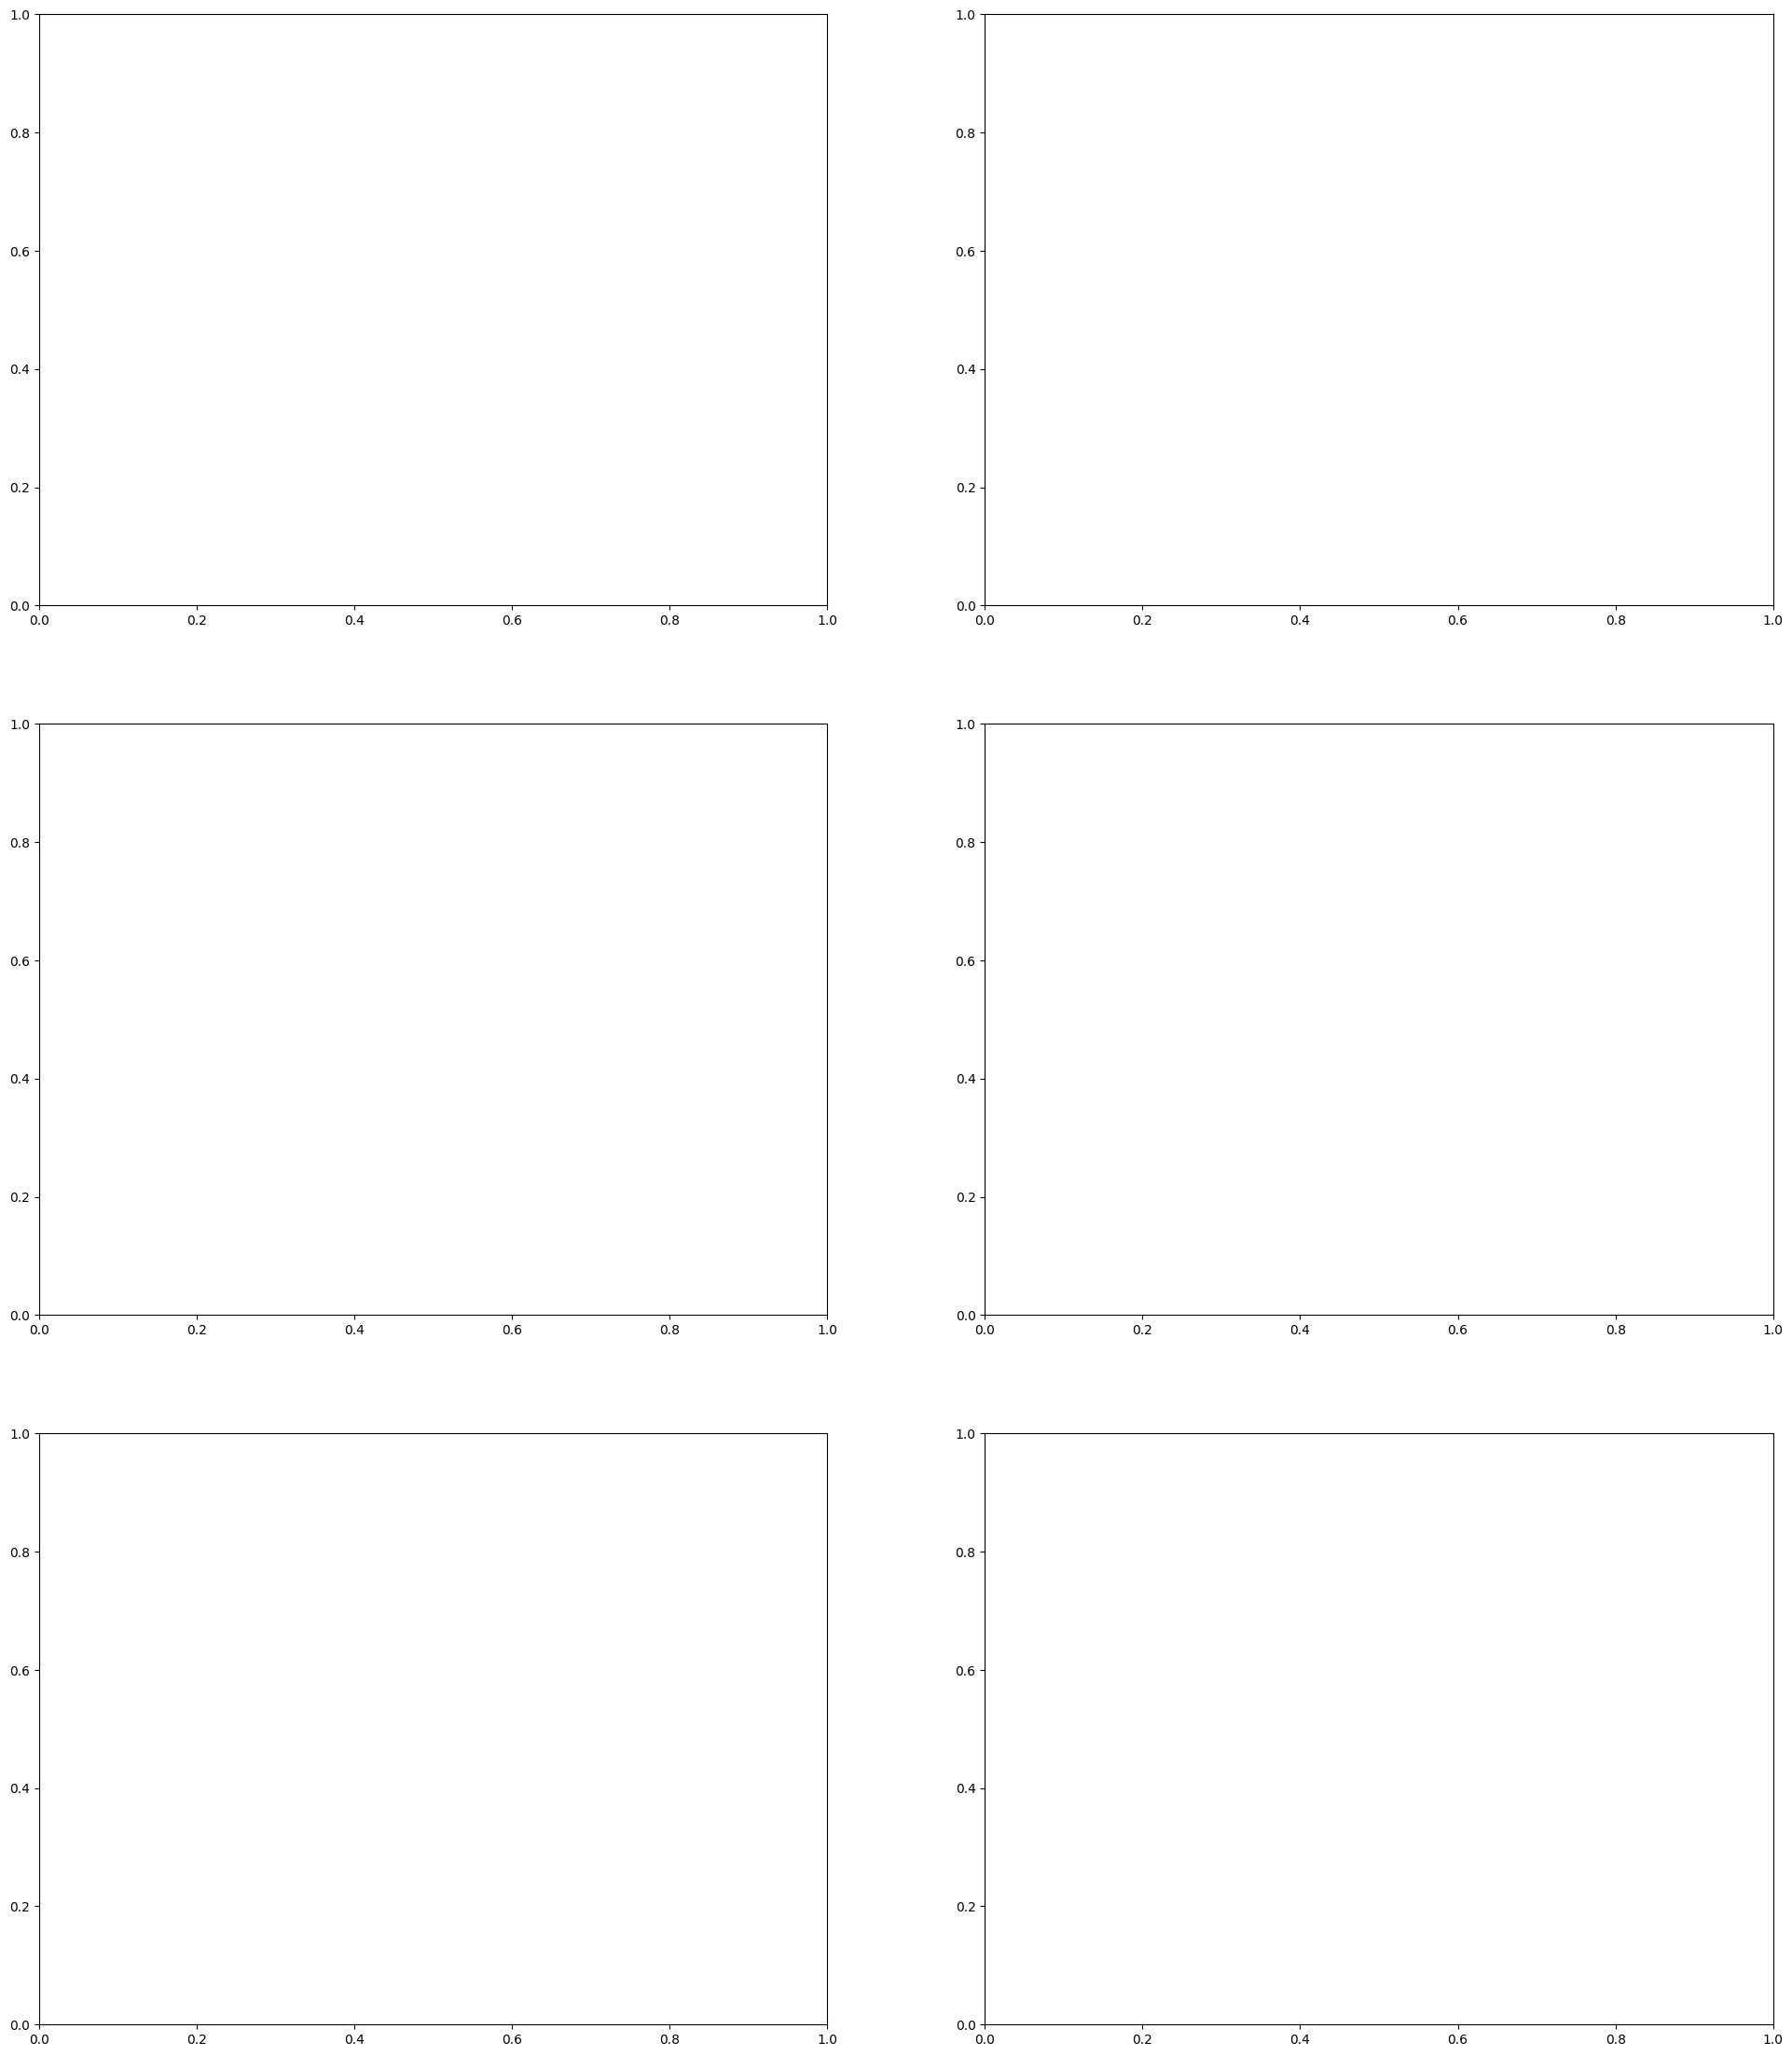

In [ ]:
model_name = "EC-Earth3"

train_split = 0.8
max_encoder_length = 10
max_prediction_length = 1

simul_start = 1970
emul_end = 2100

y_var = "ssie"
x_vars = ['tas', 'wsiv', 'oht_atl', 'oht_pac'] 

output_dict = {}

for i, model_name in enumerate(MODEL_NAMES):
    # Calculation end of simulation period
    simul_end = model_ensemble_icefree_years[model_name].min().year
    emul_start = simul_end + 1

    # Set up training config
    train_config = TrainConfig(
        y_var, x_vars, train_split, simul_start,
        simul_end, emul_start, emul_end, model_name,
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length
    )

    # Calculate train/test data
    train_config.set_all_data()
    train_config.set_simul_data()
    train_config.set_emul_df()

    train_dataloader = get_timeseries_dataloader(train_config.simul_train, train_config, train=True)
    val_dataloader = get_timeseries_dataloader(train_config.simul_test, train_config, train=False)
    emul_dataloader = get_timeseries_dataloader(train_config.emul_df, train_config, train=False)

    # Train model
    model = get_timeseries_model(train_dataloader, val_dataloader)

    # Generate ground truths
    y_test_emul = train_config.get_emul_test_df()
    y_test_simul = train_config.get_simul_test_df()

    # Generate simulations/emulations
    simulations = model.predict(val_dataloader, return_index=True)
    emulations = model.predict(emul_dataloader, return_index=True)

    simulations_df = reshape_prediction(simulations, y_test_simul.index, target="ssie")
    emulations_df = reshape_prediction(emulations, y_test_emul.index, target="ssie")

    output_dict[model_name] = Output(
        y_test_emul,
        emulations_df,
        y_test_simul,
        simulations_df,
        train_config,
        model,
    )

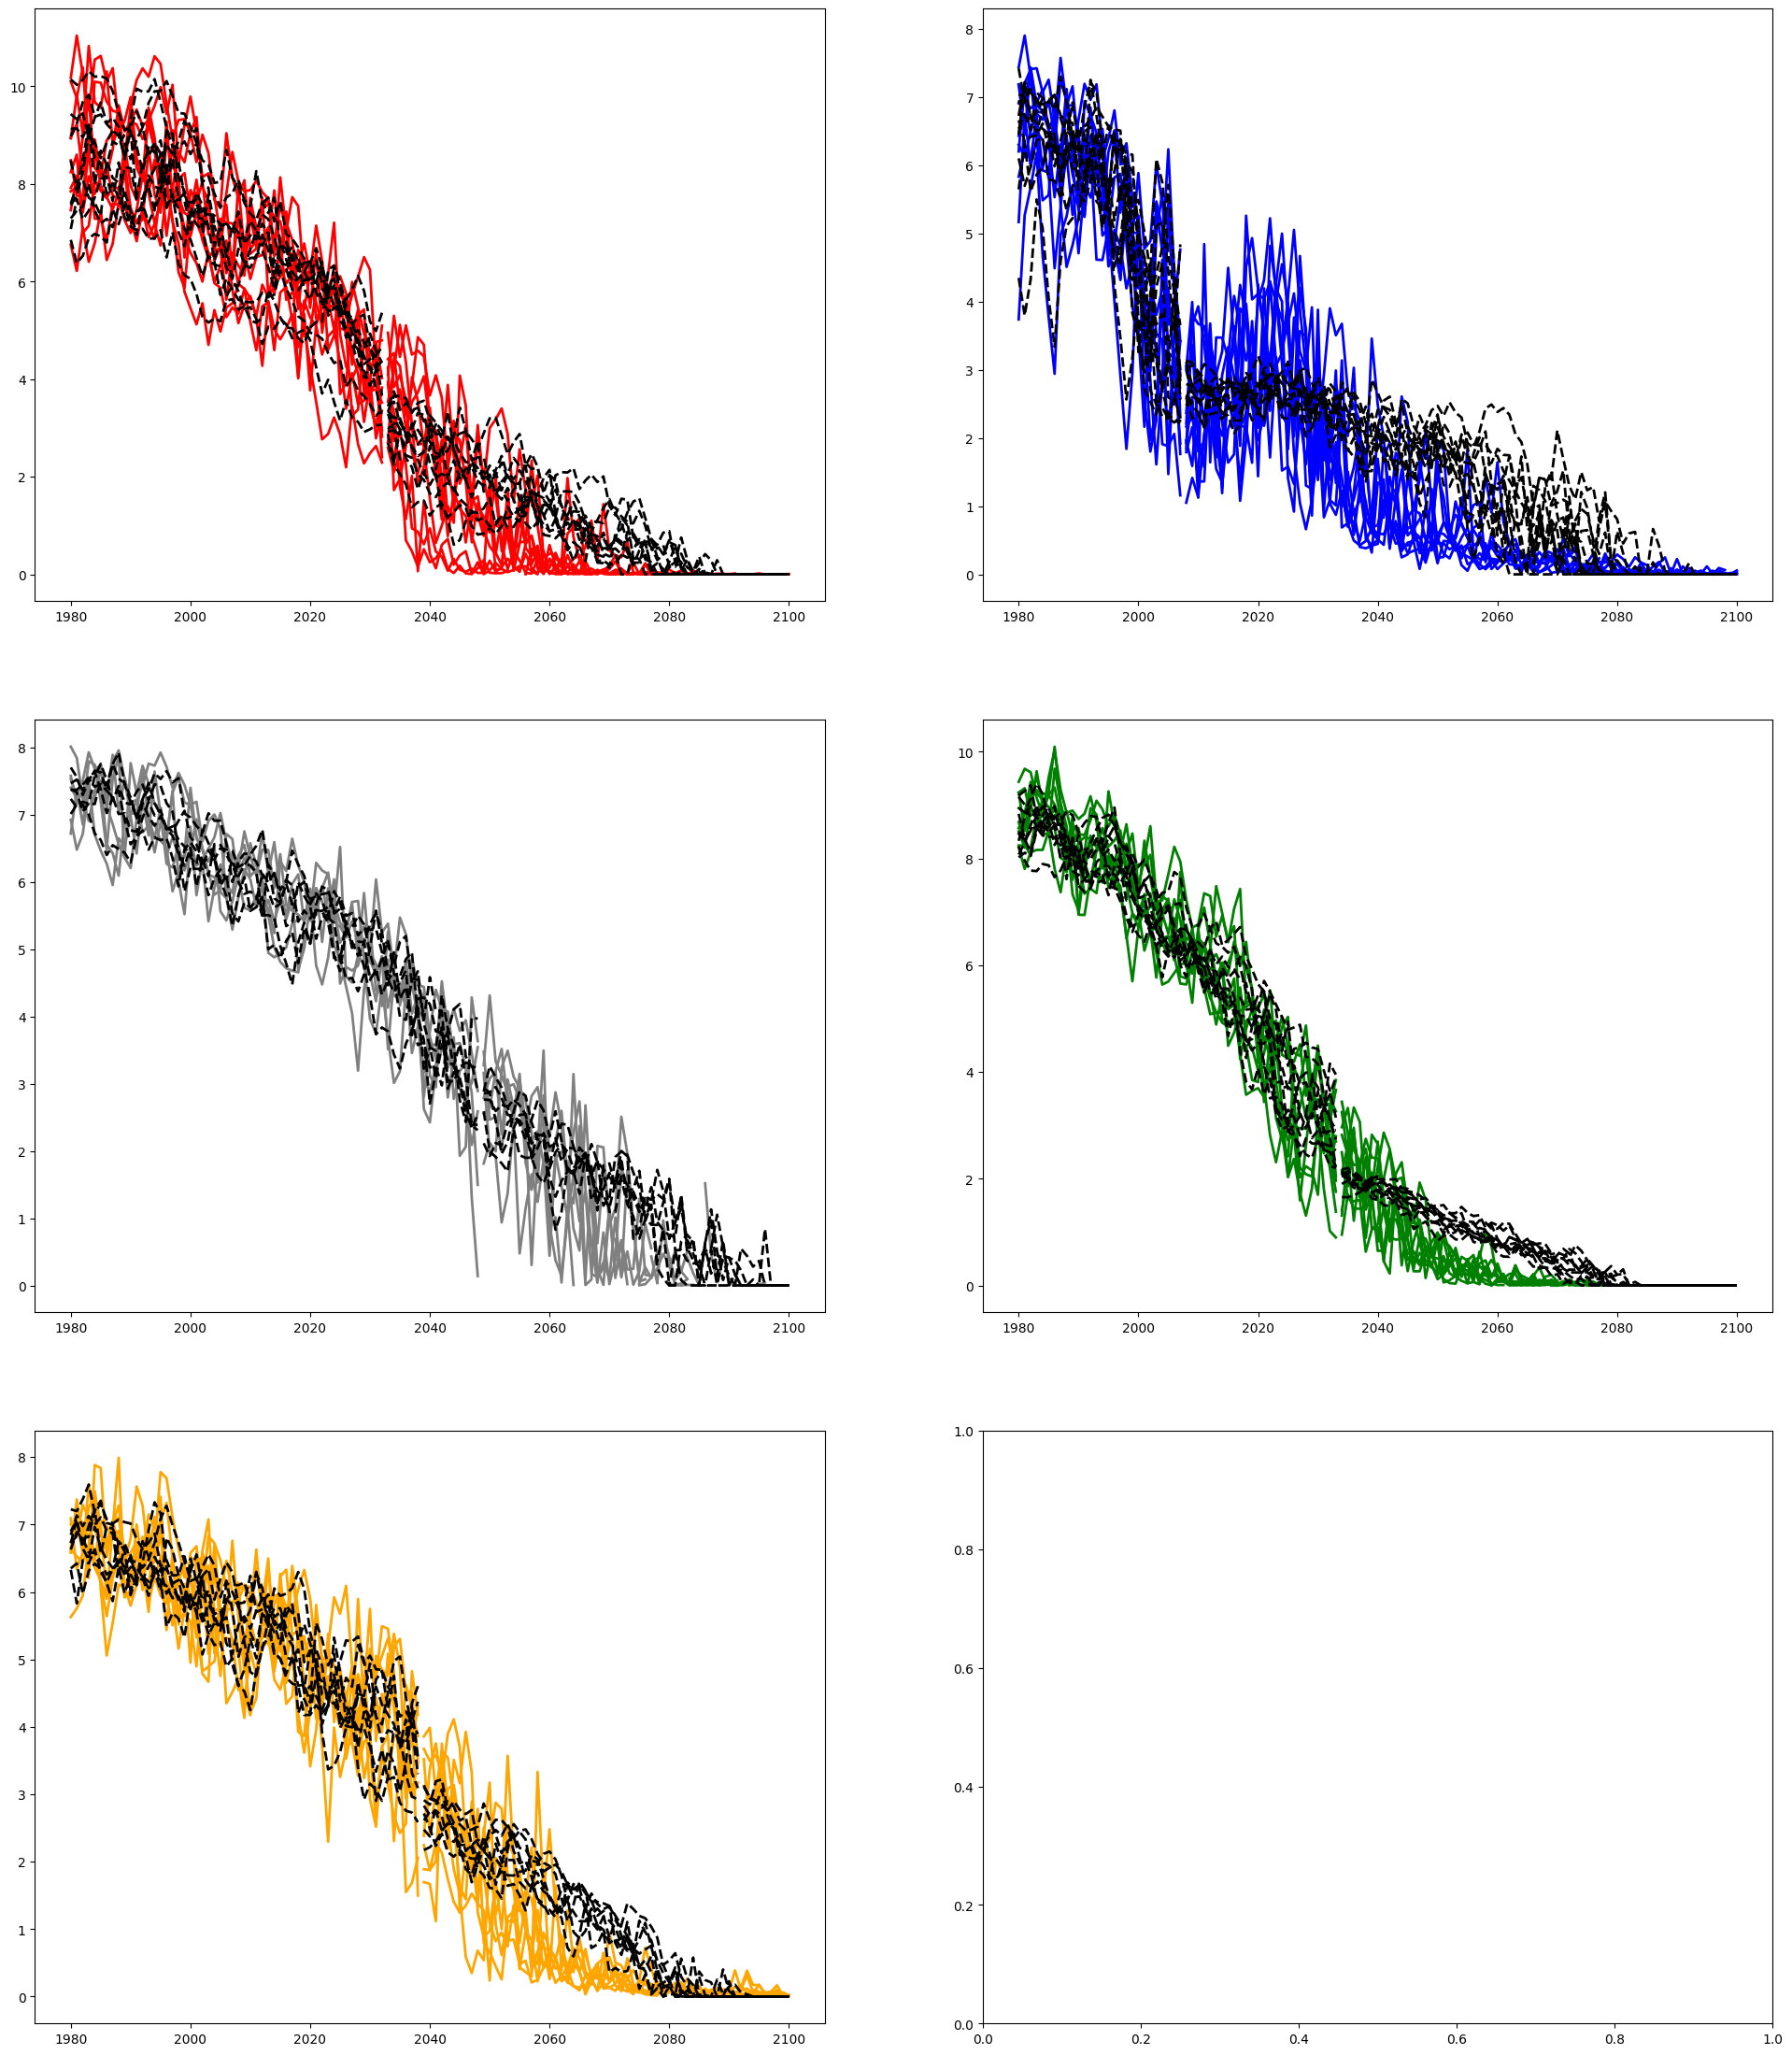

In [90]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 28))
axes = axes.flatten()

for i, (model_name, output) in enumerate(output_dict.items()):
    ax = axes[i]
    model_color = MODEL_COLOURS[model_name]

    ax.plot(output.y_test_simul, color=model_color, linewidth=2)
    _= ax.plot(output.y_pred_simul, color="black", linestyle="--", linewidth=2)

    ax.plot(output.y_test_emul, color=model_color, linewidth=2)
    _= ax.plot(output.y_pred_emul, color="black", linestyle="--", linewidth=2)

In [131]:
output_dict["EC-Earth3"].y_pred_emul.shape

(68, 10)

In [91]:
model_output_data = ModelData(output_dict)

In [171]:
dt = 1
n_iter = 1000
liang_start = "1980-01-01"
liang_end = "2060-01-01"
var_liangs = ["wsiv", "tas", "oht_atl", "oht_pac"]
target_var = "ssie"

liang_res = calculate_all_liang_flows(model_data, target_var, var_liangs, liang_start, liang_end)
liang_res_emulated = calculate_all_liang_flows(model_output_data, target_var, var_liangs, liang_start, liang_end)

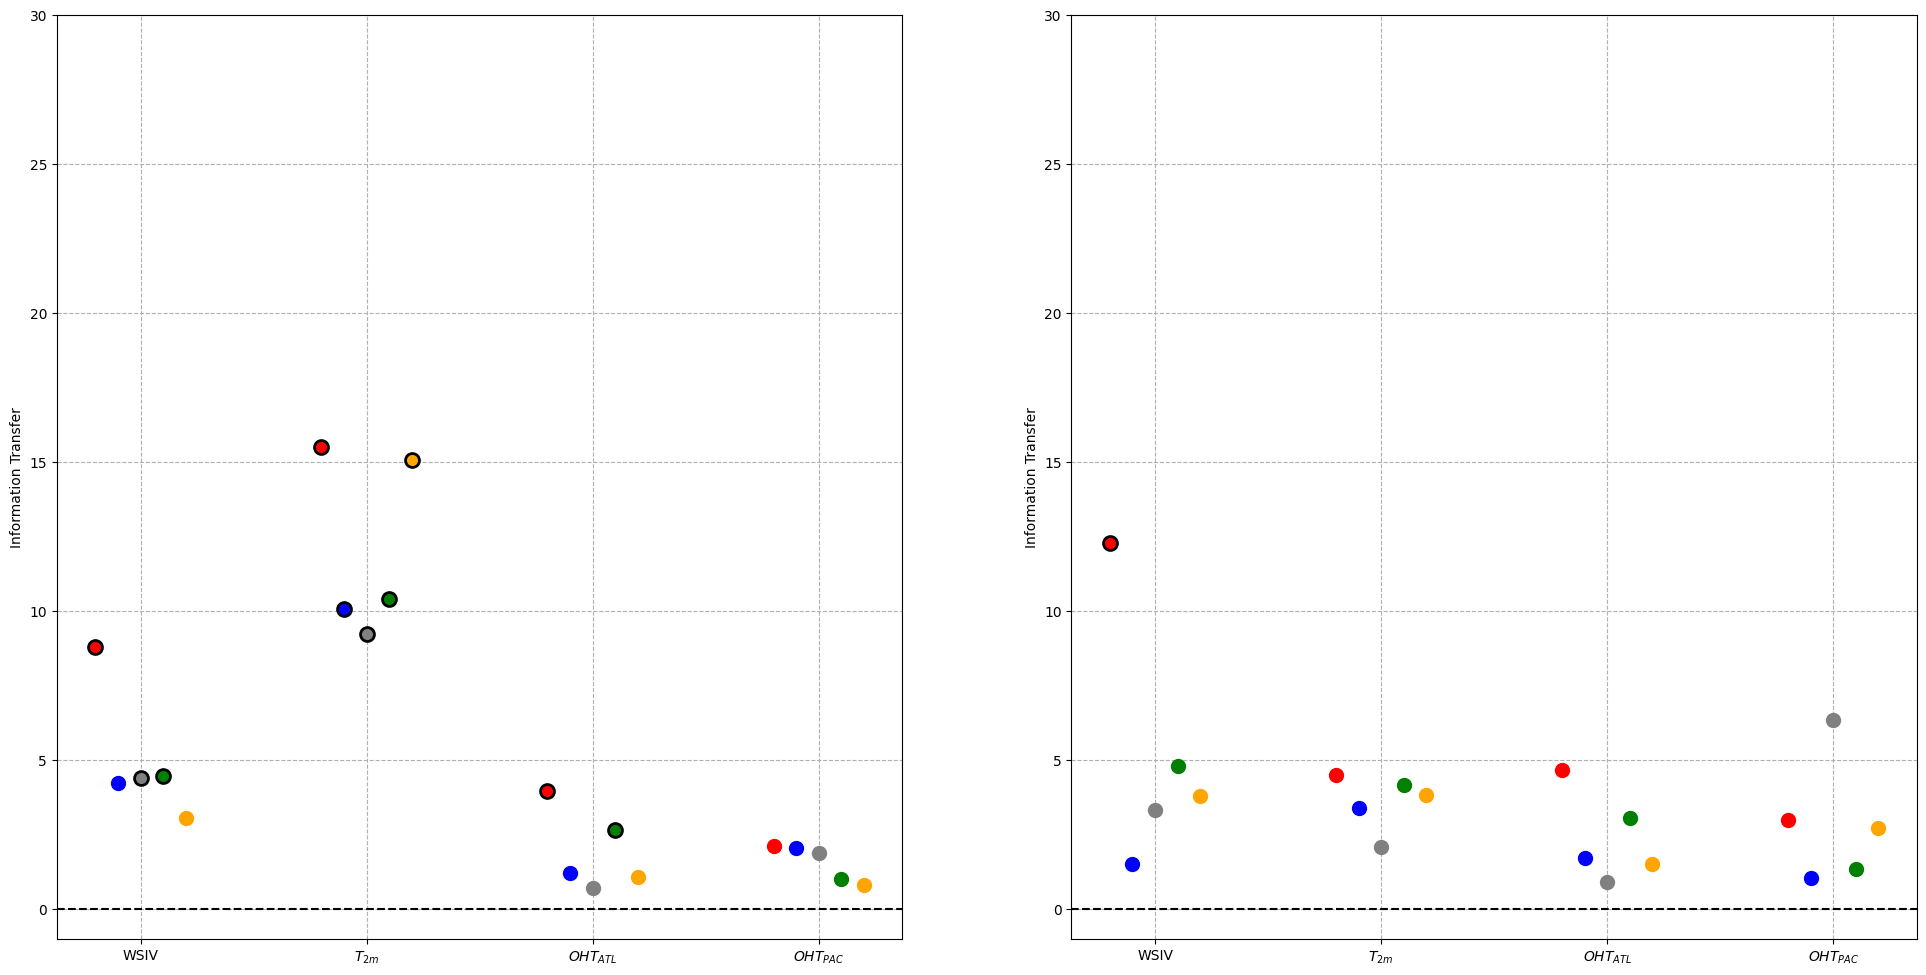

In [173]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))

plot_liang_tau_avgs(axes[0], liang_res, var_liangs)
plot_liang_tau_avgs(axes[1], liang_res_emulated, var_liangs)

## Bias Correction

In [ ]:
from cmethods import adjust
from cmethods.core import apply_ufunc
from sklearn.metrics import mean_squared_error
import xarray as xr

import warnings

# Supprime tous les UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
bias_methods = {
    "linear_scaling": {"group": "time.month", "kind": "+"},
    "variance_scaling": {"group": "time.month", "kind": "+"},
    "quantile_mapping": {"n_quantiles": 250, "kind": "+"},
}

In [ ]:
def get_bias_corrected_members(model_df: DataFrame, bias_method: str, obsh, simh, simp) -> DataFrame:
    results_b = []
    for i in model_df.columns:
        result = apply_ufunc(
            method=bias_method,
            obs=obsh,
            simh=simh.isel(ensemble=i),
            simp=simp.isel(ensemble=i),
            **kwargs,
        )
        results_b.append(result.values)

    results_b = DataFrame(results_b).T
    results_b.index = model_df.index

    return results_b

bias_corrections = {}

for bias_method, kwargs in bias_methods.items():

    bias_corrections[bias_method] = {}

    for var in VAR_NAMES:

        bias_corrections[bias_method][var] = {}

        for model_name in MODEL_NAMES:

            ensemble_df = model_data[var][model_name]
            obsh_s = model_data[var]["Observations"]
            obsh = xr.DataArray(obsh_s, coords=[obsh_s.index], dims=["time"], name="observations")
            simp = xr.DataArray(
                ensemble_df.values.T,
                coords={
                    "ensemble": ensemble_df.columns,
                    "time": ensemble_df.index,
                },
                dims=["ensemble", "time"],
                name="all_ensembles",
            )
            simh = simp.sel(time=obsh.time).rename("historical_ensembles")

            bias_corrections[bias_method][var][model_name] = get_bias_corrected_members(ensemble_df, bias_method, obsh, simh, simp)


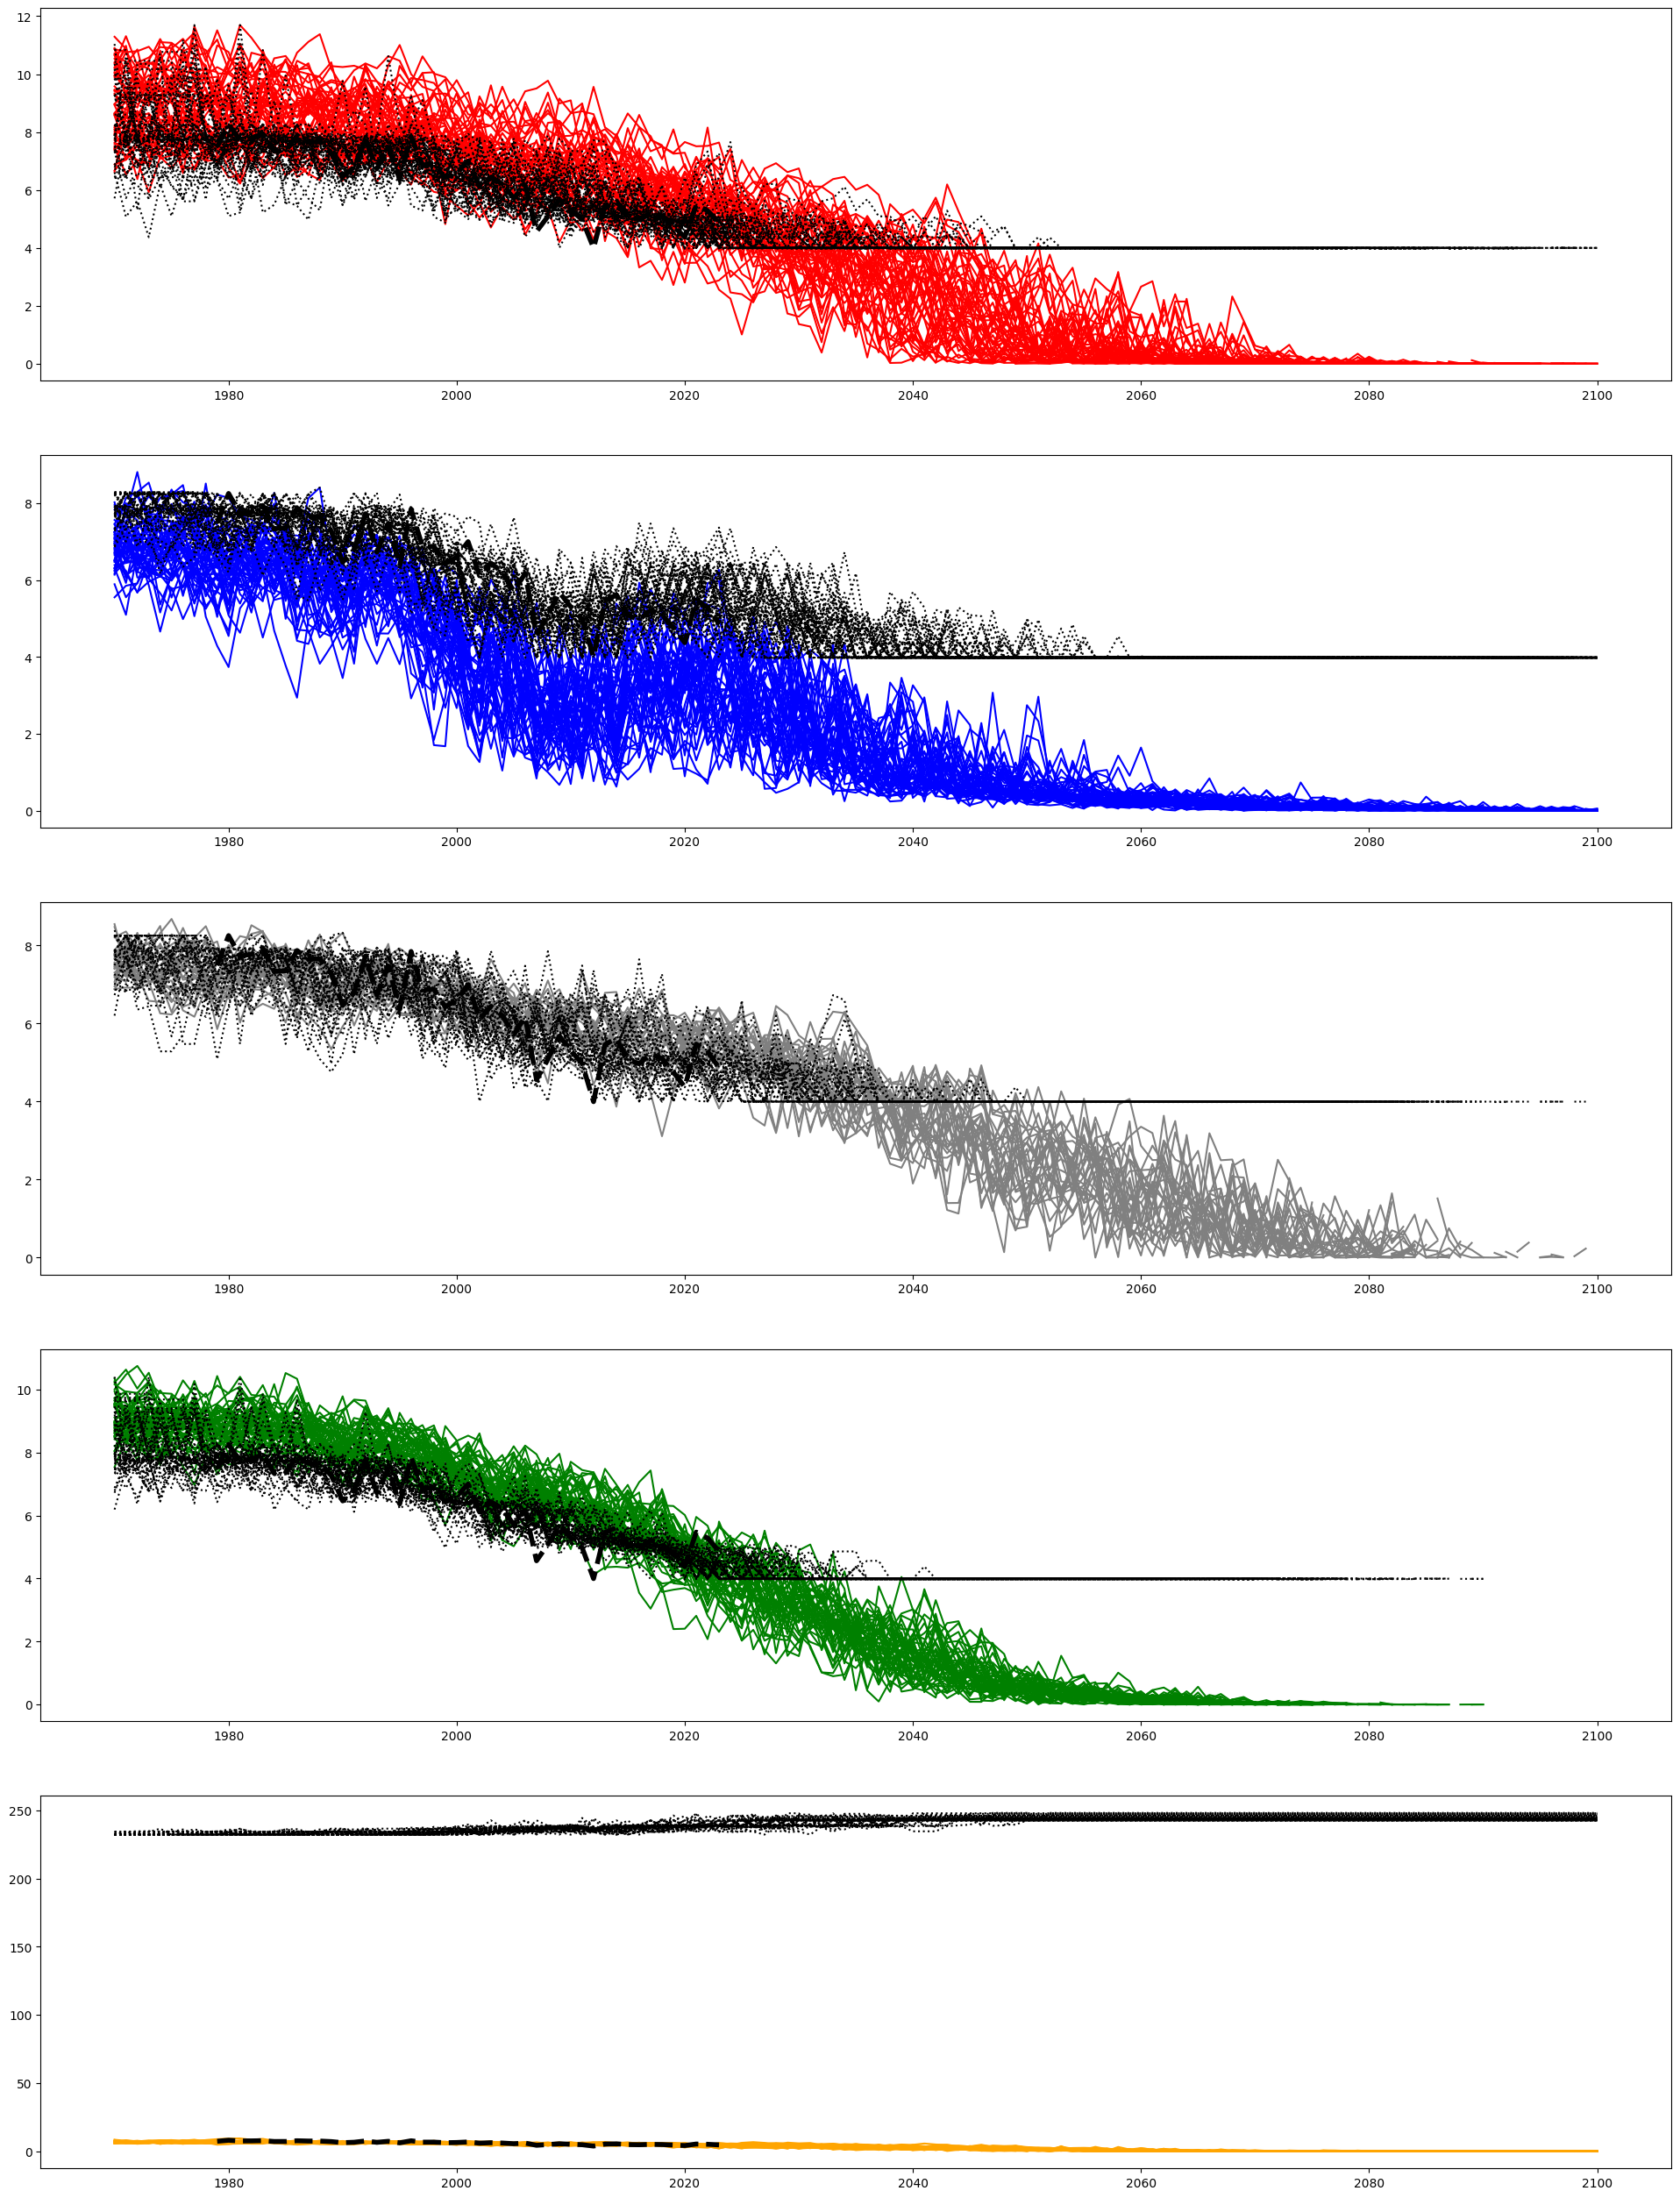

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(24, 32))
axes = axes.flatten()

var = "ssie"

for i, ax in enumerate(axes):
    model_name = MODEL_NAMES[i]
    model_color = MODEL_COLOURS[model_name]

    ensemble_df = model_data[var][model_name]
    result_df = model_bias_corrections[model_name]["quantile_mapping"]
    obsh_s = model_data[var]["Observations"]

    ax.plot(ensemble_df, color=model_color)
    ax.plot(result_df, color="black", linestyle=":")
    ax.plot(obsh_s.index, obsh_s,'k--', linewidth=4, label=model_name)

### Bias Corrected Ice Free Year Distributions

In [ ]:
bias_corrected_icefree_years = {
    bias_method: {
        model_name: calculate_first_icefree_year(bias_corrections[bias_method]["ssie"][model_name])
        for model_name in MODEL_NAMES 
    }
    for bias_method in bias_methods.keys() 
}

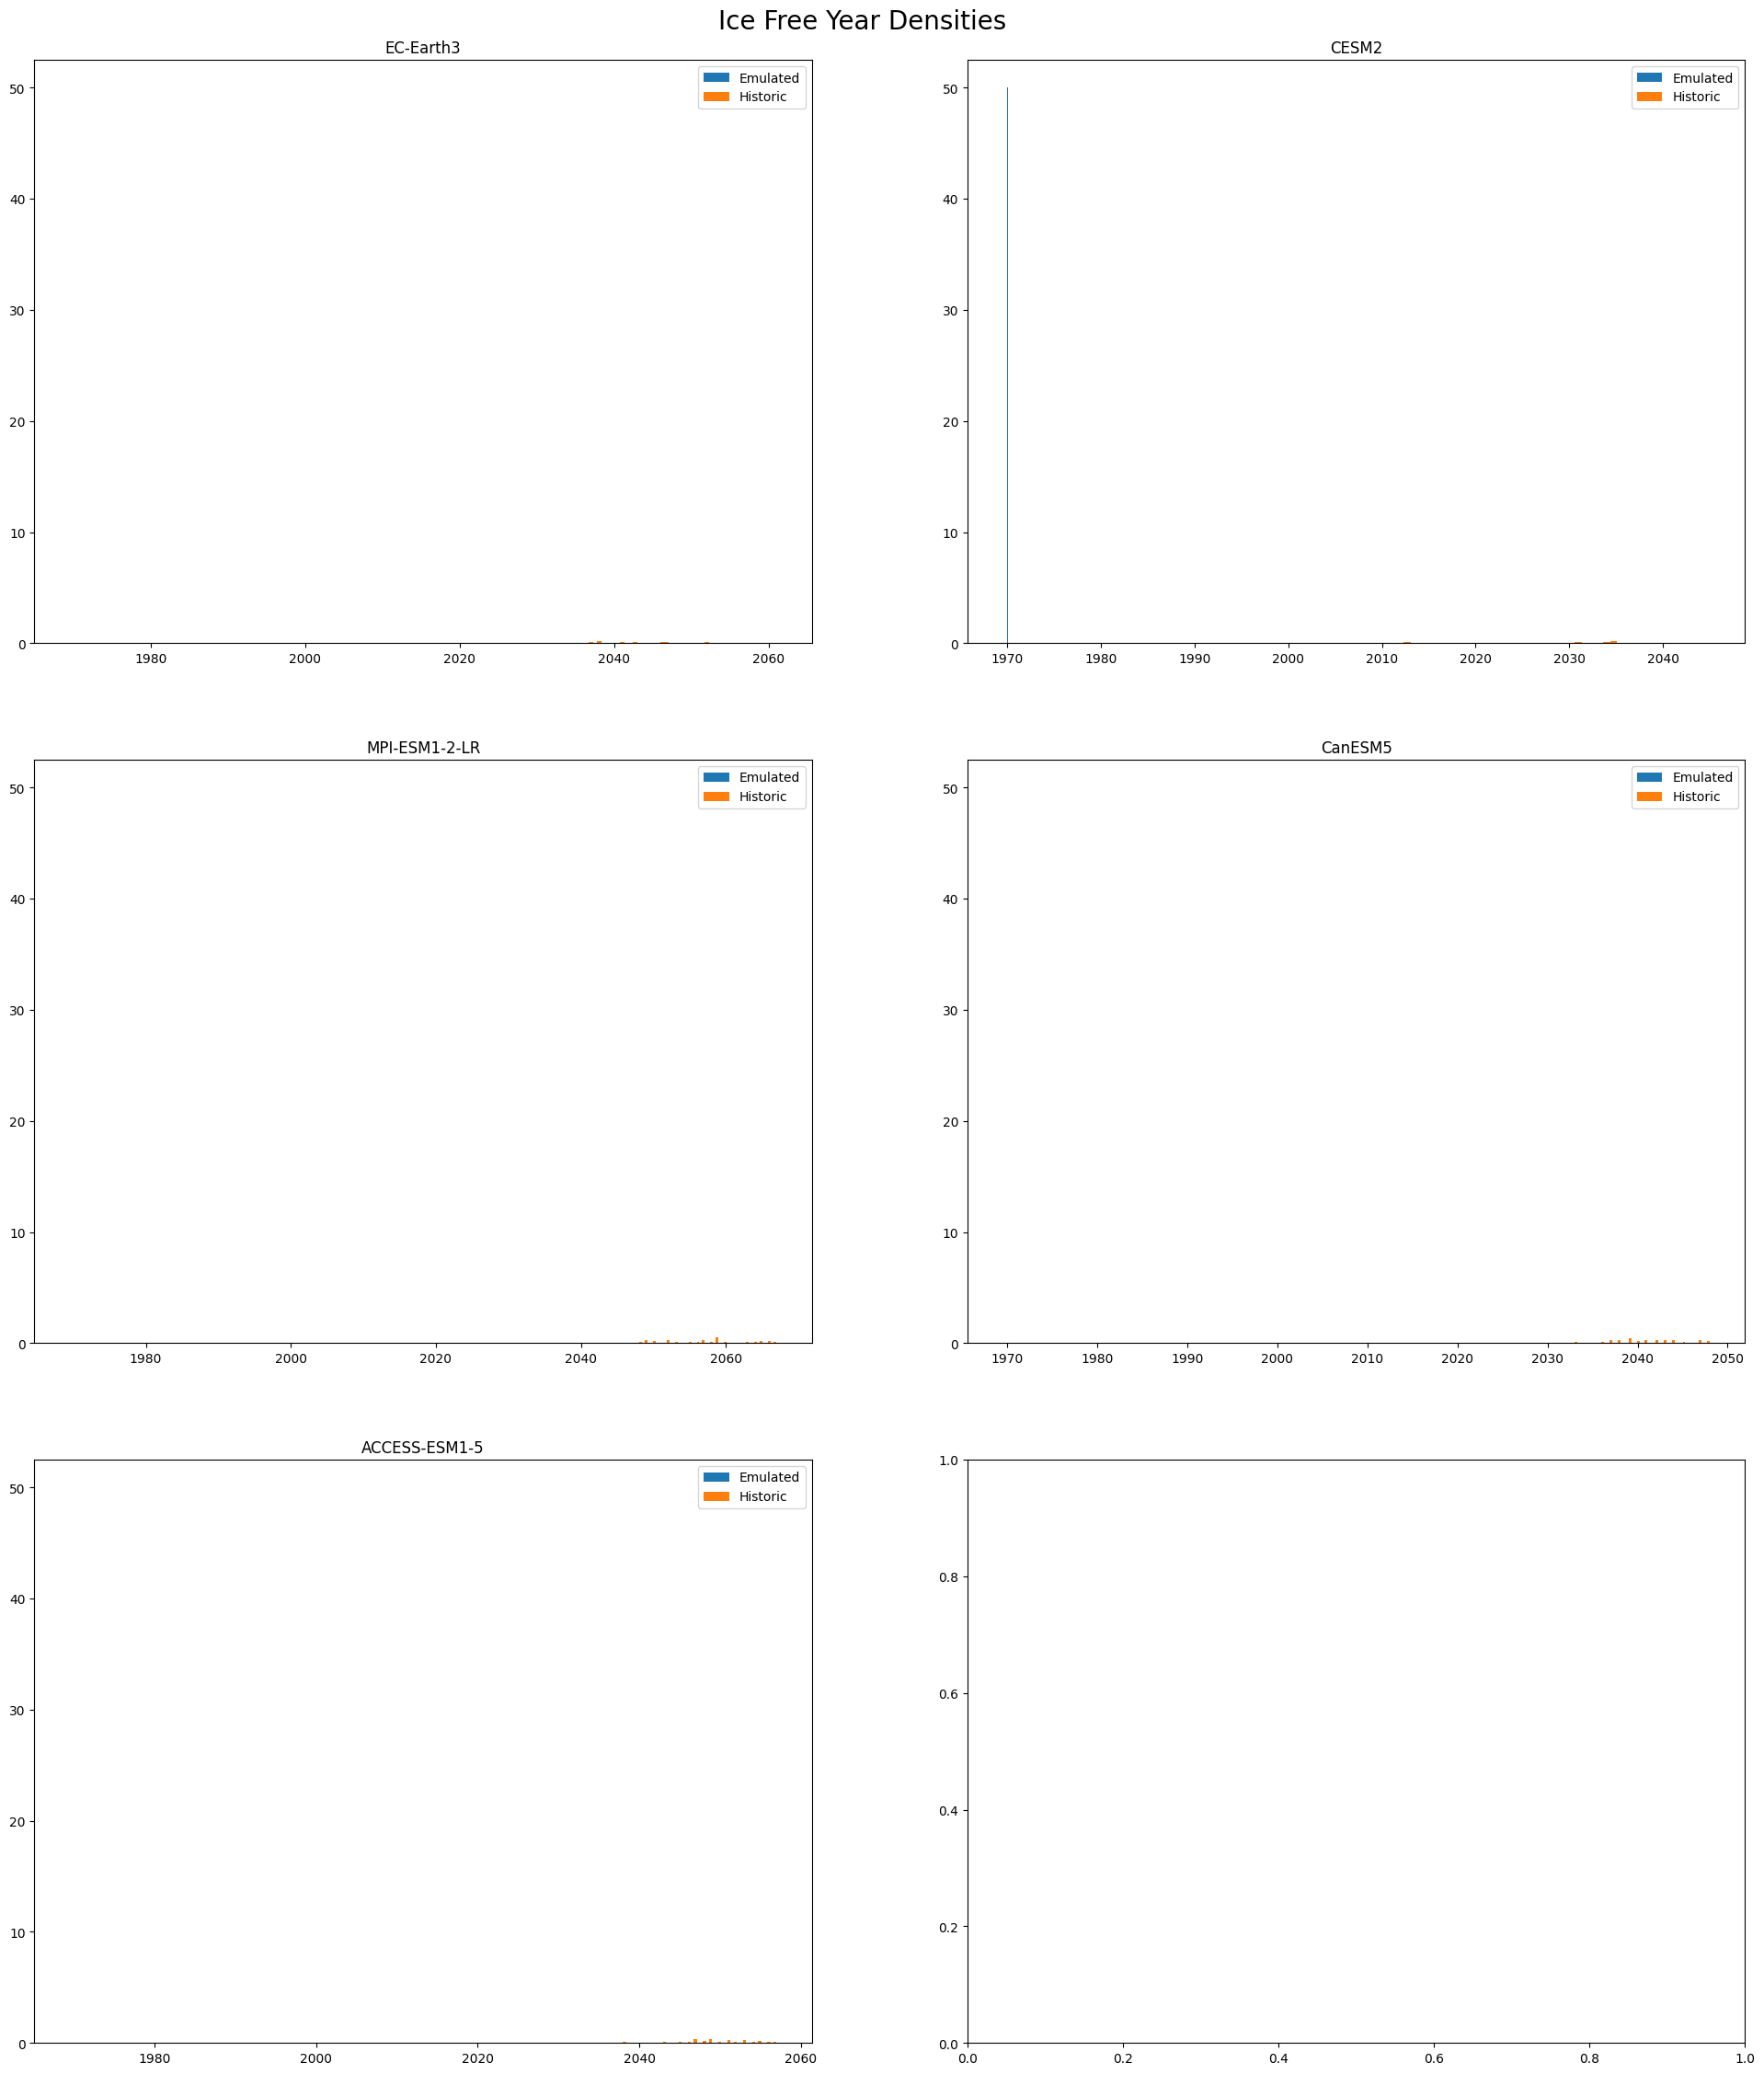

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 28))
axes = axes.flatten()

bias_method = "quantile_mapping"

for i, model_name in enumerate(MODEL_NAMES):
    ax = axes[i]
    emulated_years = bias_corrected_icefree_years[bias_method][model_name].dt.year
    data_years = model_ensemble_icefree_years[model_name].dt.year
    plot_ice_free_year_dist(ax, model_name, emulated_years, data_years)
    
_ = fig.suptitle("Ice Free Year Densities", y=0.9, size=20)

## Ice Free Year Emulation

In [ ]:
x_vars = ['tas'] # ['wsie', 'wsiv', 'tas', 'oht_atl', 'oht_pac', 'swfd', 'lwfd'] 
y_var = "ssie"
n_iter = 100

emulated_ice_free_years = {}

for model_name in MODEL_NAMES:
    # Calculation end of simulation period
    simul_end = model_ensemble_icefree_years[model_name].min().year
    emul_start = simul_end + 1

    # Set up training config
    train_config = TrainConfig(
        y_var, x_vars, train_split, simul_start,
        simul_end, emul_start, emul_end, model_name
    )

    emulated_ice_free_years[model_name] = get_emulated_ice_free_years(train_config, n_iter)



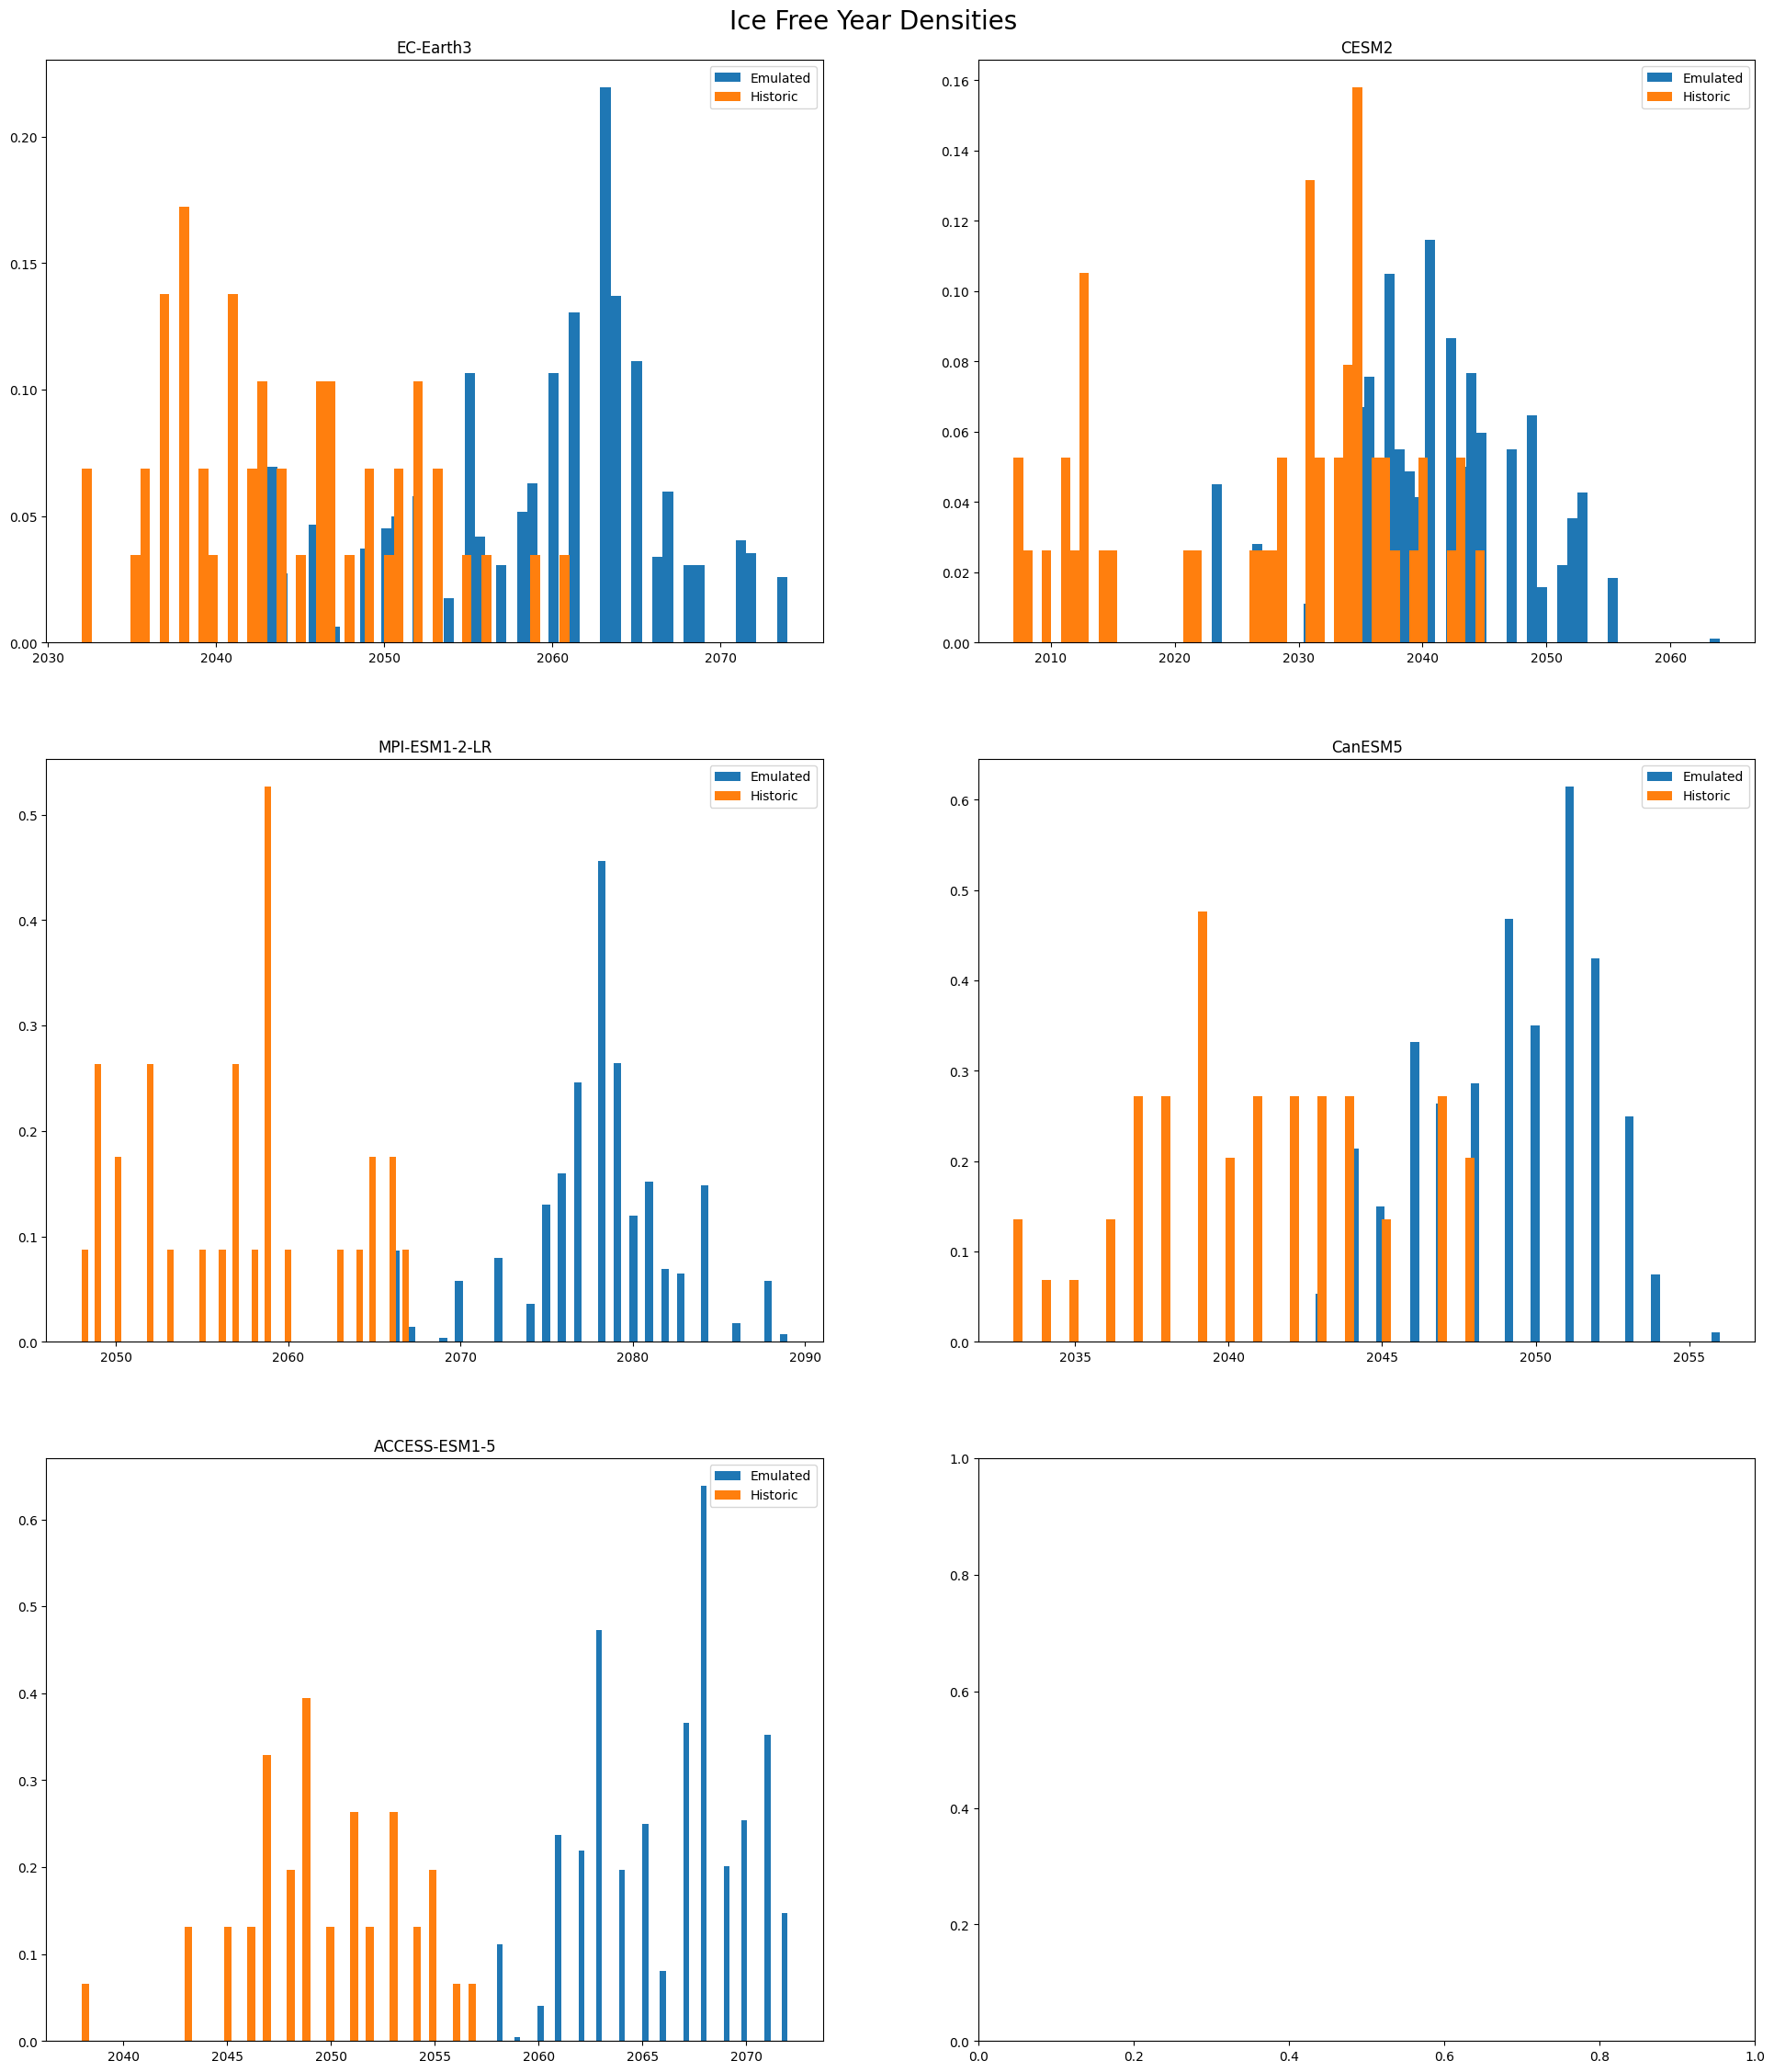

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 28))
axes = axes.flatten()

for i, model_name in enumerate(MODEL_NAMES):
    ax = axes[i]
    emulated_years = emulated_ice_free_years[model_name]
    data_years = model_ensemble_icefree_years[model_name].dt.year
    plot_ice_free_year_dist(ax, model_name, emulated_years, data_years)
    
_ = fig.suptitle("Ice Free Year Densities", y=0.9, size=20)

In [ ]:


MULTI_LIANG_RES_NAMES = [
    "T",
    "tau",
    "R",
    "error_T",
    "error_tau",
    "error_R",
]
VAR_YLABELS_SHORT = {
    "ssie": "SSIE",
    "wsie": "WSIE",
    "tas": "$T_{2m}$",
    "wsiv": "WSIV",
    "oht_atl": "$OHT_{ATL}$",
    "oht_pac": "$OHT_{PAC}$",
}







In [ ]:
dt = 1
n_iter = 1000
liang_start = "1970-01-01"
liang_end = "2060-01-01"
var_liangs = ["wsiv", "tas", "oht_atl", "oht_pac"]


liang_res = calculate_all_liang_flows(model_data, "ssie", var_liangs, liang_start, liang_end)

In [ ]:
emulated_model_data = ModelData(outputs)

dt = 1
n_iter = 1000
liang_start = "1970-01-01"
liang_end = "2060-01-01"
var_liangs = ["wsiv", "tas", "oht_atl", "oht_pac"]

liang_res_emulated = calculate_all_liang_flows(emulated_model_data, "ssie", var_liangs, liang_start, liang_end)

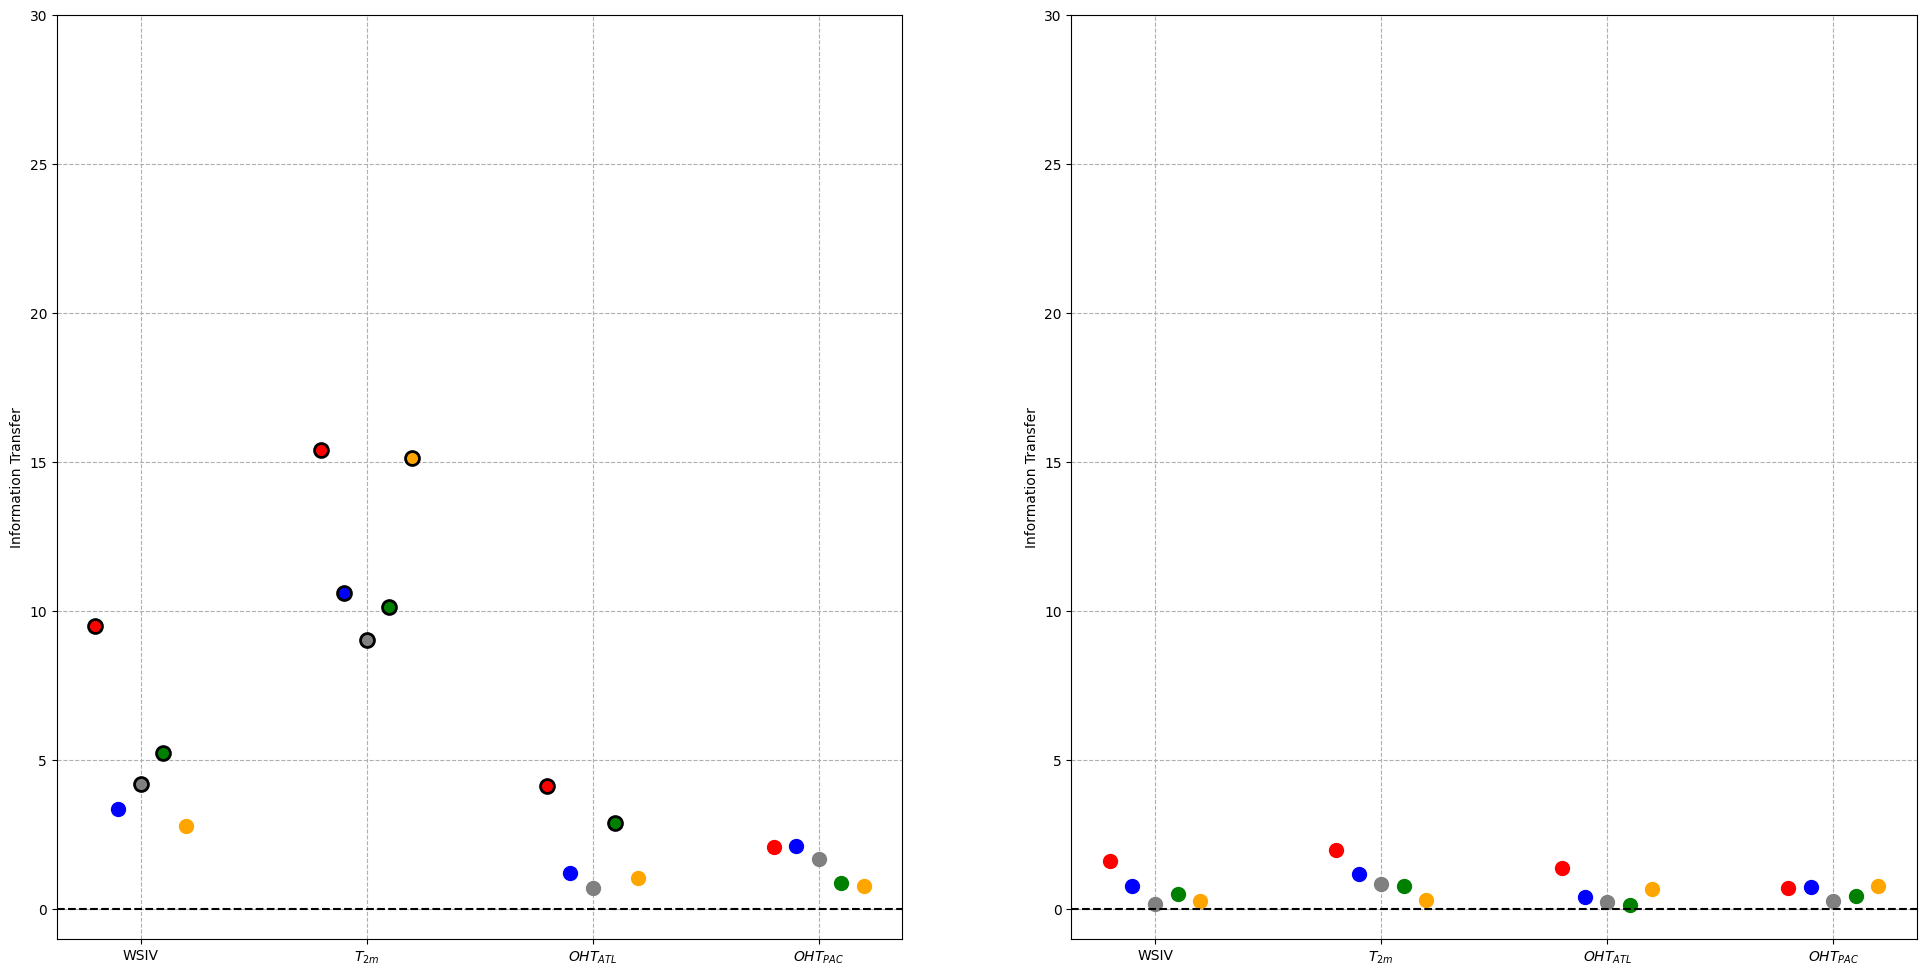

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))

plot_liang_tau_avgs(axes[0], liang_res, var_liangs)
plot_liang_tau_avgs(axes[1], liang_res_emulated, var_liangs)